# Import all Necessary libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Intially we used PyTorch for preprocessing.
**Why PyTorch:**
- Easy: Beginner-friendly and readable.
- GPU-Compatible
- Rich Data Augmentation: Built-in tools like random crop, flip, rotation, color jitter — applied efficiently.
- Seamless with DataLoader: Integrates perfectly with PyTorch DataLoader for batching, shuffling, and real-time augmentations

In [ ]:
import os
import sys
import cv2
import albumentations as A
from glob import glob
import random
import shutil
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import PIL
import torch
import torchvision
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from collections import Counter
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
torch.backends.cudnn.deterministic = True


import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("matplotlib version:", matplotlib.__version__)
print("pandas version:", pd.__version__)
print("PIL version:", PIL.__version__)
print("torch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)

Platform: linux
Python version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
---
matplotlib version: 3.10.0
pandas version: 2.2.2
PIL version: 11.2.1
torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


## Exploring dataset

In [ ]:
# !cd /content/drive/MyDrive/dataset/Dataset_BUSI_with_GT

In [ ]:
 images_dir = "/content/drive/MyDrive/Breast_cancer_segementation/Dataset_BUSI_with_GT"

print("Images:", images_dir)

Images: /content/drive/MyDrive/Breast_cancer_segementation/Dataset_BUSI_with_GT


In [ ]:
classes = os.listdir(images_dir)

print("List of classes:", classes)

List of classes: ['malignant', 'benign', 'normal', 'Models']


**We have three classes of Breast Cancer**

Lets check the number of images in each class

In [ ]:
benign_path = os.path.join(images_dir, "benign")
benign_images = os.listdir(benign_path)
print("length of benign images: ", len(benign_images))

malignant_path = os.path.join(images_dir, "malignant")
malignant_images = os.listdir(malignant_path)
print("length of malignant images: ", len(malignant_images))

normal_path = os.path.join(images_dir, "normal")
normal_images = os.listdir(normal_path)
print("length of normal images: ", len(normal_images))

length of benign images:  891
length of malignant images:  421
length of normal images:  266


**We can clearly see that the classes are unbalance. This is one of the problem with dataset we will deal with these in preprocessing section**

- **Now let count the no of images and their correspond mask in each class**

In [ ]:
6paths = glob(images_dir + "/*/*")
print(f"'normal' class has {len([i for i in paths if 'normal' in i and 'mask' not in i])} images and {len([i for i in paths if 'normal' in i and 'mask' in i])} masks.")
print(f"'benign' class has {len([i for i in paths if 'benign' in i and 'mask' not in i])} images and {len([i for i in paths if 'benign' in i and 'mask' in i])} masks.")
print(f"'malignant' class has {len([i for i in paths if 'malignant' in i and 'mask' not in i])} images and {len([i for i in paths if 'malignant' in i and 'mask' in i])} masks.")
print(f"\nThere are total of {len([i for i in paths if 'mask' not in i])} images and {len([i for i in paths if 'mask' in i])} masks.")

'normal' class has 133 images and 133 masks.
'benign' class has 437 images and 454 masks.
'malignant' class has 210 images and 211 masks.

There are total of 780 images and 798 masks.


In [ ]:
import os
from glob import glob

benign_path = os.path.join(images_dir, "benign")
benign_images = os.listdir(benign_path)
print("length of benign images: ", len(benign_images))

length of benign images:  891


**The reason behind the unequal no of images and mask is that some of the images have more than one mask image, we have to merge these mask images into a single mask image. This is our second problem that we have to tackle**

## Size of images

In [ ]:
benign_image_name = benign_images[0]
print(benign_image_name)

benign_image_path = os.path.join(benign_path , benign_image_name)
print(benign_image_path)

print()

malignant_image_name = malignant_images[0]
print(malignant_image_name)

malignant_image_path = os.path.join(malignant_path , malignant_image_name)
print(malignant_image_path)

print()

normal_image_name = normal_images[1]
print(normal_image_name)

normal_image_path = os.path.join(normal_path , normal_image_name)
print(normal_image_path)

benign (108)_mask.png
/content/drive/MyDrive/dataset/Dataset_BUSI_with_GT/benign/benign (108)_mask.png

malignant (105).png
/content/drive/MyDrive/dataset/Dataset_BUSI_with_GT/malignant/malignant (105).png

normal (11).png
/content/drive/MyDrive/dataset/Dataset_BUSI_with_GT/normal/normal (11).png


In [ ]:
benign_img_pil = Image.open(benign_image_path)
print("Benign image: ", benign_img_pil.mode, benign_img_pil.size)

malignant_img_pil = Image.open(malignant_image_path)
print("malignant image: ", malignant_img_pil.mode, malignant_img_pil.size)

normal_img_pil = Image.open(normal_image_path)
print("normal image: ", normal_img_pil.mode, normal_img_pil.size)

Benign image:  1 (769, 582)
malignant image:  RGB (577, 450)
normal image:  RGB (752, 576)


**The images are in RGB mode or channel but the size of the images is different we have to bring all images in the same scale (Normalization)**


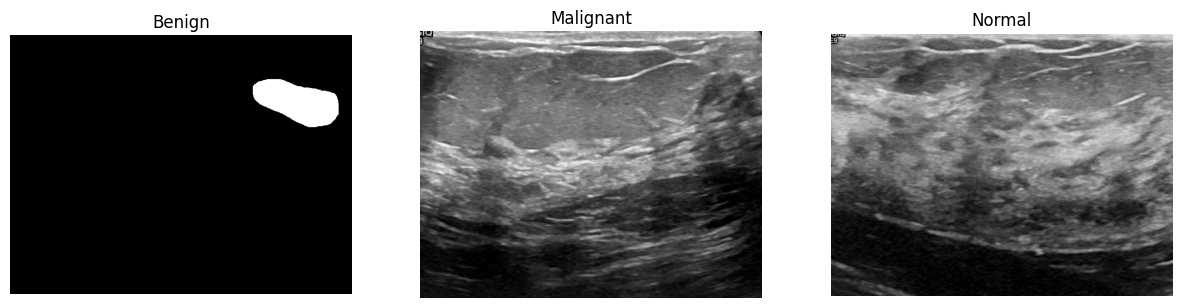

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display each image
axes[0].imshow(benign_img_pil)
axes[0].set_title("Benign")
axes[0].axis('off')

axes[1].imshow(malignant_img_pil)
axes[1].set_title("Malignant")
axes[1].axis('off')

axes[2].imshow(normal_img_pil)
axes[2].set_title("Normal")
axes[2].axis('off')

plt.show()

# Multimask images

['benign (100).png', 'benign (100)_mask.png', 'benign (100)_mask_1.png']


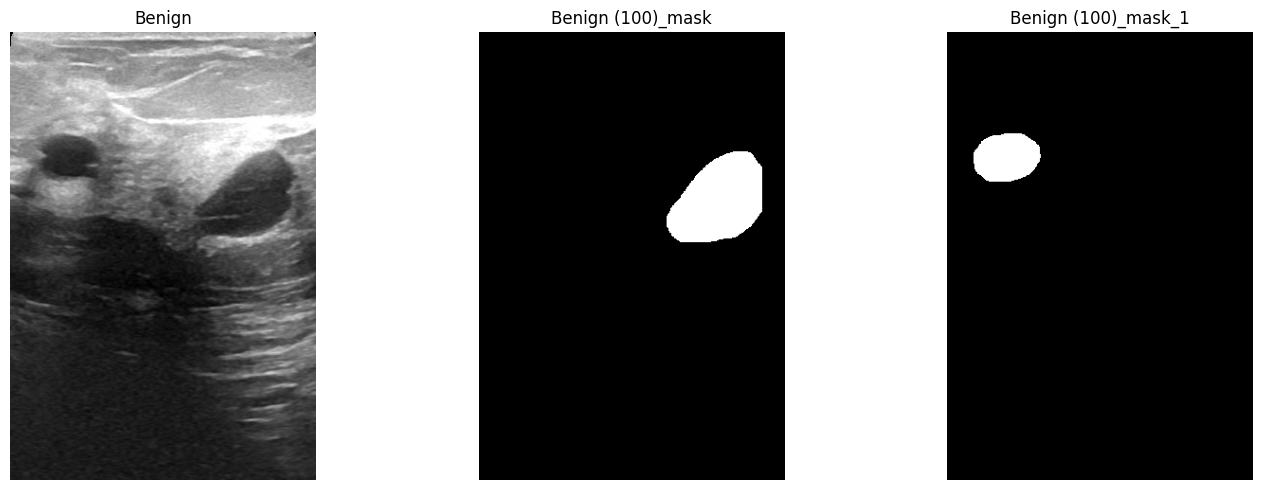

In [ ]:
# Get the 3 image names
benign_image_name = ['benign (100).png', 'benign (100)_mask.png','benign (100)_mask_1.png']
print(benign_image_name)

# Load all 3 images first
images = []
for img_name in benign_image_name:
    img_path = os.path.join(benign_path, img_name)
    img = Image.open(img_path)
    images.append(img)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(images[0])
axes[0].set_title("Benign")
axes[0].axis('off')

axes[1].imshow(images[1])
axes[1].set_title("Benign (100)_mask")
axes[1].axis('off')

axes[2].imshow(images[2])
axes[2].set_title("Benign (100)_mask_1")
axes[2].axis('off')

plt.tight_layout()
plt.show()

**So, Here we can see that some the images have separete mask for each breast we have to merge these images into a single image.
this is the reason that no of images and mask images is not equal**

# Preprocessing Section

## Merging multiple mask into a single mask

In [ ]:
import os
from PIL import Image
import numpy as np

# Define categories
categories = ['benign', 'malignant', 'normal']

def merge_masks(mask_files):
    """Combine multiple binary masks into a single mask using logical OR."""
    merged_mask = None
    for mask_file in mask_files:
        mask = np.array(Image.open(mask_file).convert('1'))  # Binary mask
        if merged_mask is None:
            merged_mask = mask
        else:
            merged_mask = np.logical_or(merged_mask, mask)  # Combine using logical OR
    return Image.fromarray(merged_mask.astype('uint8') * 255)  # Convert to 0–255 for saving

for category in categories:
    category_path = os.path.join(images_dir, category)
    all_files = os.listdir(category_path)

    # Group masks by base image name (remove the "_mask" and any suffixes)
    mask_groups = {}
    for file in all_files:
        if '_mask' in file:  # Identify mask files
            base_name = file.split('_mask')[0]  # Get base name without "_mask"
            if base_name not in mask_groups:
                mask_groups[base_name] = []
            mask_groups[base_name].append(os.path.join(category_path, file))

    # Merge masks and delete duplicates
    for base_name, mask_files in mask_groups.items():
        if len(mask_files) > 1:  # If there are multiple masks for the same base image
            print(f"[{category}] Merging {len(mask_files)} masks for {base_name}...")
            merged_mask = merge_masks(mask_files)

            # Save the merged mask as a single mask image
            merged_mask_path = os.path.join(category_path, f"{base_name}_mask.png")
            merged_mask.save(merged_mask_path)

            # Delete all original mask files except the merged one
            for mask_file in mask_files:
                if mask_file != merged_mask_path:  # Skip the newly created merged mask
                    os.remove(mask_file)
                    print(f"Deleted: {mask_file}")

print("✅ All overlapping masks merged and cleaned up!")


✅ All overlapping masks merged and cleaned up!


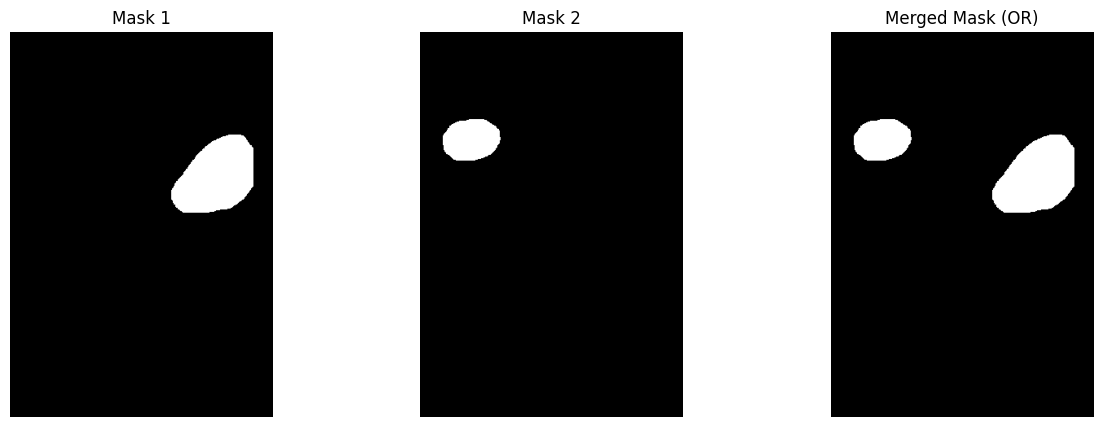

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Paths (replace with your actual paths)
base_name = "benign (100)"  # Example image
mask1_path = "/content/benign (100)_mask.png"
mask2_path = "/content/benign (100)_mask_1.png"

# Load masks and convert to binary (0 or 1)
mask1 = np.array(Image.open(mask1_path).convert('1'))  # Binary mask (True/False)
mask2 = np.array(Image.open(mask2_path).convert('1'))

# Combine masks using logical OR (if either mask has a pixel, keep it)
merged_mask = np.logical_or(mask1, mask2)

# Convert back to PIL Image (0=black, 255=white)
merged_mask_pil = Image.fromarray(merged_mask.astype('uint8') * 255)

# Display the original masks and merged result
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(mask1, cmap='gray')
axes[0].set_title("Mask 1")
axes[0].axis('off')

axes[1].imshow(mask2, cmap='gray')
axes[1].set_title("Mask 2")
axes[1].axis('off')

axes[2].imshow(merged_mask, cmap='gray')
axes[2].set_title("Merged Mask (OR)")
axes[2].axis('off')

plt.show()

we merged two single mask in a single image

['benign (100).png', 'benign (100)_mask.png']


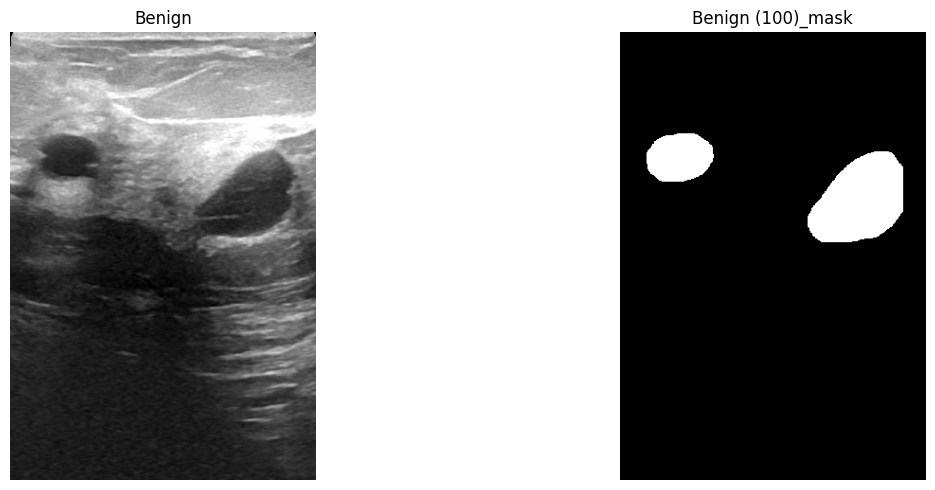

In [ ]:
# Get the 3 image names
benign_image_name = ['benign (100).png', 'benign (100)_mask.png']
print(benign_image_name)

# Load all 3 images first
images = []
for img_name in benign_image_name:
    img_path = os.path.join(benign_path, img_name)
    img = Image.open(img_path)
    images.append(img)

# Now display them side by side in a single row
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 3 columns

# Assign each image to a subplot
axes[0].imshow(images[0])
axes[0].set_title("Benign")
axes[0].axis('off')

axes[1].imshow(images[1],cmap = 'gray')
axes[1].set_title("Benign (100)_mask")
axes[1].axis('off')

plt.tight_layout()  # Prevents overlapping titles
plt.show()

- **Now let count again the no of images and their correspond mask in each class**

In [ ]:
paths = glob(images_dir + "/*/*")
print(f"'normal' class has {len([i for i in paths if 'normal' in i and 'mask' not in i])} images and {len([i for i in paths if 'normal' in i and 'mask' in i])} masks.")
print(f"'benign' class has {len([i for i in paths if 'benign' in i and 'mask' not in i])} images and {len([i for i in paths if 'benign' in i and 'mask' in i])} masks.")
print(f"'malignant' class has {len([i for i in paths if 'malignant' in i and 'mask' not in i])} images and {len([i for i in paths if 'malignant' in i and 'mask' in i])} masks.")
print(f"\nThere are total of {len([i for i in paths if 'mask' not in i])} images and {len([i for i in paths if 'mask' in i])} masks.")

'normal' class has 133 images and 133 masks.
'benign' class has 437 images and 437 masks.
'malignant' class has 210 images and 210 masks.

There are total of 780 images and 780 masks.


**we have succesfully merged the images and the tolat no of images is equal to their correspond mask images**

# Unblance Class Distribution

In [ ]:
# Load dataset
dataset = datasets.ImageFolder(root=images_dir)
print(f"Dataset classes: {dataset.classes}")  # Verify class names

def class_counts(dataset):
    # Count occurrences of each class
    c = Counter(x[1] for x in tqdm(dataset, desc="Counting classes"))

    # Map class indices to names (e.g., {0: 'benign', 1: 'malignant', 2: 'normal'})
    class_to_index = dataset.class_to_idx  # Fixed: No extra .dataset

    # Invert the mapping (e.g., {'benign': 0, 'malignant': 1, 'normal': 2})
    index_to_class = {v: k for k, v in class_to_index.items()}

    # Return counts with class names
    return pd.Series({index_to_class[idx]: count for idx, count in c.items()})

# Get class counts
class_counts = class_counts(dataset)
print(class_counts)

Dataset classes: ['benign', 'malignant', 'normal']


Counting classes:   0%|          | 0/1560 [00:00<?, ?it/s]

benign       874
malignant    420
normal       266
dtype: int64


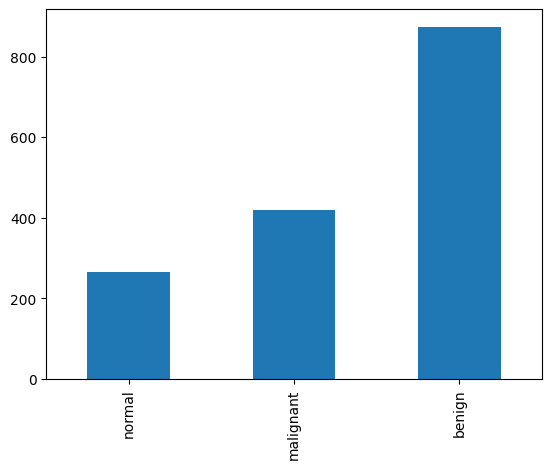

In [ ]:
class_counts.sort_values().plot(kind="bar");

# Data Spliting Part 80% for training and 20% for validation

In [ ]:
# Config
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32
DATASET_DIR = images_dir  # Replace with your path

# Class mapping
CLASS_MAP = {"benign": 1, "malignant": 2, "normal": 3}
CLASS_MAP_INV = {v:k for k,v in CLASS_MAP.items()}  # For visualization
IMAGE_EXTENSIONS = [".png", ".jpg", ".jpeg"]

def load_paths():
    image_mask_pairs = []
    for class_name, class_id in CLASS_MAP.items():
        class_dir = os.path.join(DATASET_DIR, class_name)
        files = os.listdir(class_dir)
        image_files = [f for f in files if "_mask" not in f and os.path.splitext(f)[-1].lower() in IMAGE_EXTENSIONS]

        for img_file in image_files:
            base_name = os.path.splitext(img_file)[0]
            image_path = os.path.join(class_dir, img_file)
            mask_path = os.path.join(class_dir, f"{base_name}_mask{os.path.splitext(img_file)[1]}")

            if os.path.exists(mask_path):
                image_mask_pairs.append((image_path, mask_path, class_id))
    return image_mask_pairs

def process_path(image_path, mask_path, class_id):
    image = load_img(image_path, target_size=IMAGE_SIZE)
    image = img_to_array(image) / 255.0
    mask = load_img(mask_path, color_mode="grayscale", target_size=IMAGE_SIZE)
    mask = img_to_array(mask)
    mask = np.where(mask > 0, class_id, 0)
    return image, mask

def load_data_with_labels():
    data = load_paths()
    images, masks, labels = [], [], []
    for img_path, mask_path, class_id in data:
        image, mask = process_path(img_path, mask_path, class_id)
        images.append(image)
        masks.append(mask)
        labels.append(class_id)
    return np.array(images), np.array(masks), np.array(labels)
# Load and split data
images, masks, labels = load_data_with_labels()
X_train, X_val, y_train, y_val, labels_train, labels_val = train_test_split(
    images, masks, labels, test_size=0.2, stratify=labels, random_state=42)

Training Data Verification:


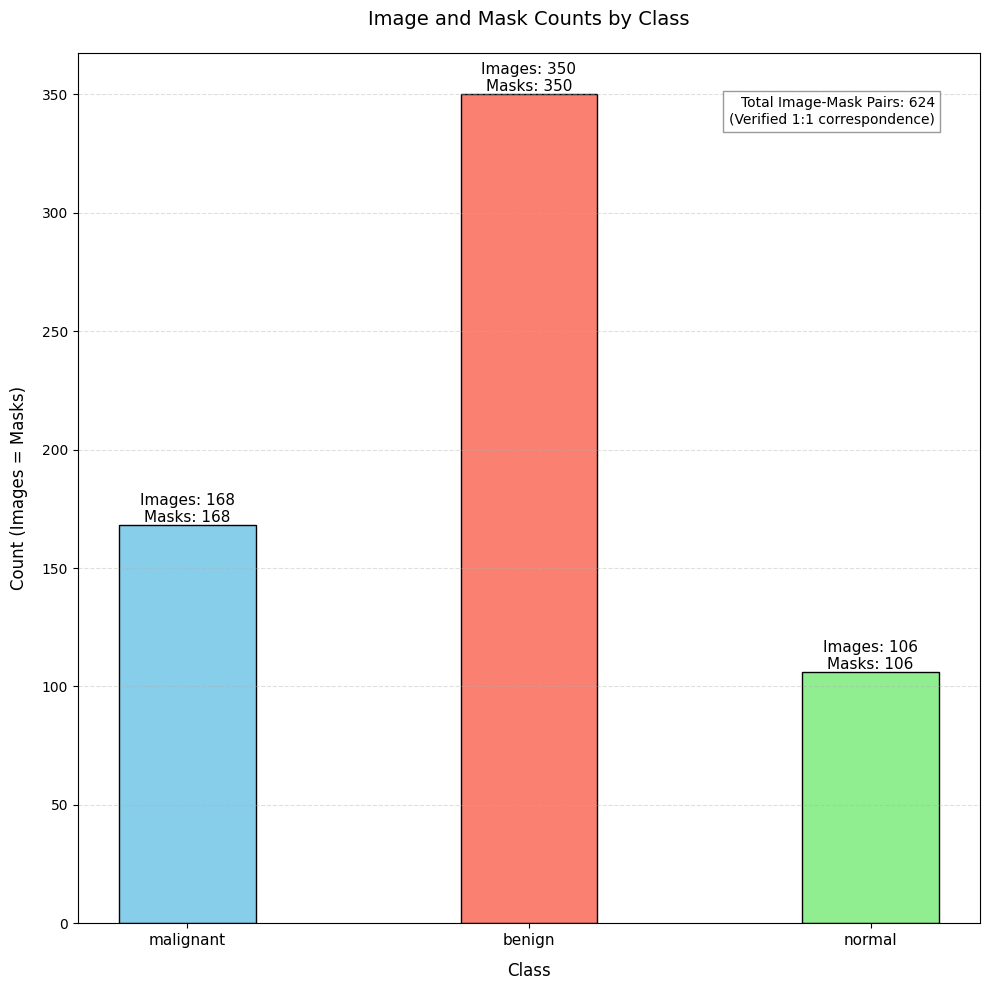

In [ ]:
def plot_image_mask_counts(X_train, y_train, labels_train):

    assert len(X_train) == len(y_train) == len(labels_train), "Mismatched array lengths!"

    # Get class counts
    class_counts = Counter(labels_train)
    classes = [CLASS_MAP_INV[c] for c in class_counts.keys()]
    counts = list(class_counts.values())

    # Create plot
    plt.figure(figsize=(10, 10))

    # Plot image counts (will be same as mask counts)
    bars = plt.bar(classes, counts, color=['skyblue', 'salmon', 'lightgreen'],
                  edgecolor='black', width=0.4)

    plt.title("Image and Mask Counts by Class", pad=20, fontsize=14)
    plt.xlabel("Class", labelpad=10, fontsize=12)
    plt.ylabel("Count (Images = Masks)", labelpad=10, fontsize=12)
    plt.xticks(fontsize=11)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height,
                f'Images: {height}\nMasks: {height}',
                ha='center', va='bottom', fontsize=11)

    # Add verification text
    total_pairs = len(X_train)
    plt.text(0.95, 0.95,
             f"Total Image-Mask Pairs: {total_pairs}\n(Verified 1:1 correspondence)",
             transform=plt.gca().transAxes,
             ha='right', va='top',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

# Usage
print("Training Data Verification:")
plot_image_mask_counts(X_train, y_train, labels_train)

# Augmentation on training dataset to blance the imbalance classes

In [ ]:
def apply_augmentation(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)


    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, mask

def balance_classes(X_train, y_train, labels_train):

    labels_train = np.array(labels_train)

    # Get indices for each class
    benign_idx = np.where(labels_train == 1)[0]  # benign
    malignant_idx = np.where(labels_train == 2)[0]  # malignant
    normal_idx = np.where(labels_train == 3)[0]  # normal

    print("Original counts:")
    print(f"Benign (1): {len(benign_idx)}")
    print(f"Malignant (2): {len(malignant_idx)}")
    print(f"Normal (3): {len(normal_idx)}")


    X_benign = X_train[benign_idx]
    y_benign = y_train[benign_idx]


    X_malignant = X_train[malignant_idx]
    y_malignant = y_train[malignant_idx]

    malignant_needed = 350 - 168  # = 182 augmentations needed
    augmented_malignant = []
    augmented_malignant_masks = []

    for _ in range(malignant_needed):
        idx = np.random.randint(0, 168)  # randomly select from original 168
        img = tf.convert_to_tensor(X_malignant[idx])
        mask = tf.convert_to_tensor(y_malignant[idx])
        aug_img, aug_mask = apply_augmentation(img, mask)
        augmented_malignant.append(aug_img.numpy())
        augmented_malignant_masks.append(aug_mask.numpy())

    # Combine original + augmented malignant
    X_malignant = np.concatenate([X_malignant, augmented_malignant])
    y_malignant = np.concatenate([y_malignant, augmented_malignant_masks])

    # 3. Normal - augment from 106 → 250 (need +144)
    X_normal = X_train[normal_idx]
    y_normal = y_train[normal_idx]

    normal_needed = 250 - 106  # = 144 augmentations needed
    augmented_normal = []
    augmented_normal_masks = []

    for _ in range(normal_needed):
        idx = np.random.randint(0, 106)  # randomly select from original 106
        img = tf.convert_to_tensor(X_normal[idx])
        mask = tf.convert_to_tensor(y_normal[idx])
        aug_img, aug_mask = apply_augmentation(img, mask)
        augmented_normal.append(aug_img.numpy())
        augmented_normal_masks.append(aug_mask.numpy())

    # Combine original + augmented normal
    X_normal = np.concatenate([X_normal, augmented_normal])
    y_normal = np.concatenate([y_normal, augmented_normal_masks])

    # Combine all classes
    X_balanced = np.concatenate([X_benign, X_malignant, X_normal])
    y_balanced = np.concatenate([y_benign, y_malignant, y_normal])
    labels_balanced = np.concatenate([
        np.full(350, 1),  # benign
        np.full(350, 2),  # malignant
        np.full(250, 3)   # normal
    ])

    # Verify
    print("\nBalanced counts:")
    print(f"Benign (1): {np.sum(labels_balanced == 1)}")
    print(f"Malignant (2): {np.sum(labels_balanced == 2)}")
    print(f"Normal (3): {np.sum(labels_balanced == 3)}")

    return X_balanced, y_balanced, labels_balanced

# Apply balancing
X_train_balanced, y_train_balanced, labels_train_balanced = balance_classes(X_train, y_train, labels_train)

Original counts:
Benign (1): 350
Malignant (2): 168
Normal (3): 106

Balanced counts:
Benign (1): 350
Malignant (2): 350
Normal (3): 250


Training Data Verification:


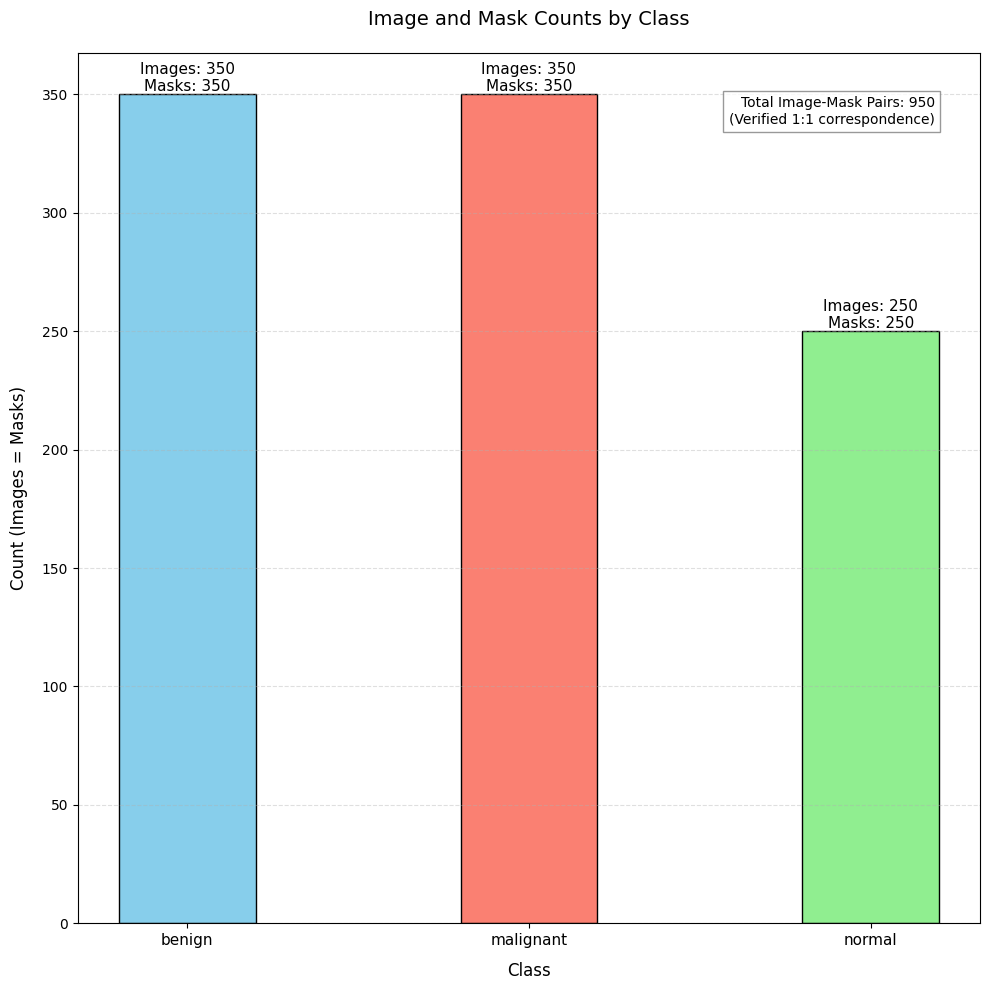

In [ ]:
def plot_image_mask_counts(X_train, y_train, labels_train):

    assert len(X_train) == len(y_train) == len(labels_train), "Mismatched array lengths!"
    class_counts = Counter(labels_train)
    classes = [CLASS_MAP_INV[c] for c in class_counts.keys()]
    counts = list(class_counts.values())


    plt.figure(figsize=(10, 10))
    bars = plt.bar(classes, counts, color=['skyblue', 'salmon', 'lightgreen'],
                  edgecolor='black', width=0.4)

    plt.title("Image and Mask Counts by Class", pad=20, fontsize=14)
    plt.xlabel("Class", labelpad=10, fontsize=12)
    plt.ylabel("Count (Images = Masks)", labelpad=10, fontsize=12)
    plt.xticks(fontsize=11)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height,
                f'Images: {height}\nMasks: {height}',
                ha='center', va='bottom', fontsize=11)

    total_pairs = len(X_train)
    plt.text(0.95, 0.95,
             f"Total Image-Mask Pairs: {total_pairs}\n(Verified 1:1 correspondence)",
             transform=plt.gca().transAxes,
             ha='right', va='top',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

print("Training Data Verification:")
plot_image_mask_counts(X_train_balanced, y_train_balanced, labels_train_balanced)

In [ ]:
def create_dataset(x, y, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    ds = ds.map(lambda a, b: (tf.cast(a, tf.float32), tf.cast(b, tf.int32)))
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# train_ds = create_dataset(X_train_balanced, y_train_balanced)
val_ds = create_dataset(X_val, y_val, shuffle=False)

print("\nFinal Dataset Sizes:")
# print(f"Balanced training samples: {len(X_train_balanced)}")
print(f"Validation samples: {len(X_val)}")


Final Dataset Sizes:
Validation samples: 156


In [ ]:
X_train_balanced.shape, y_train_balanced.shape, X_val.shape, y_val.shape

((950, 256, 256, 3),
 (950, 256, 256, 1),
 (156, 256, 256, 3),
 (156, 256, 256, 1))

# Some of the images with their repective mask image in train dataset

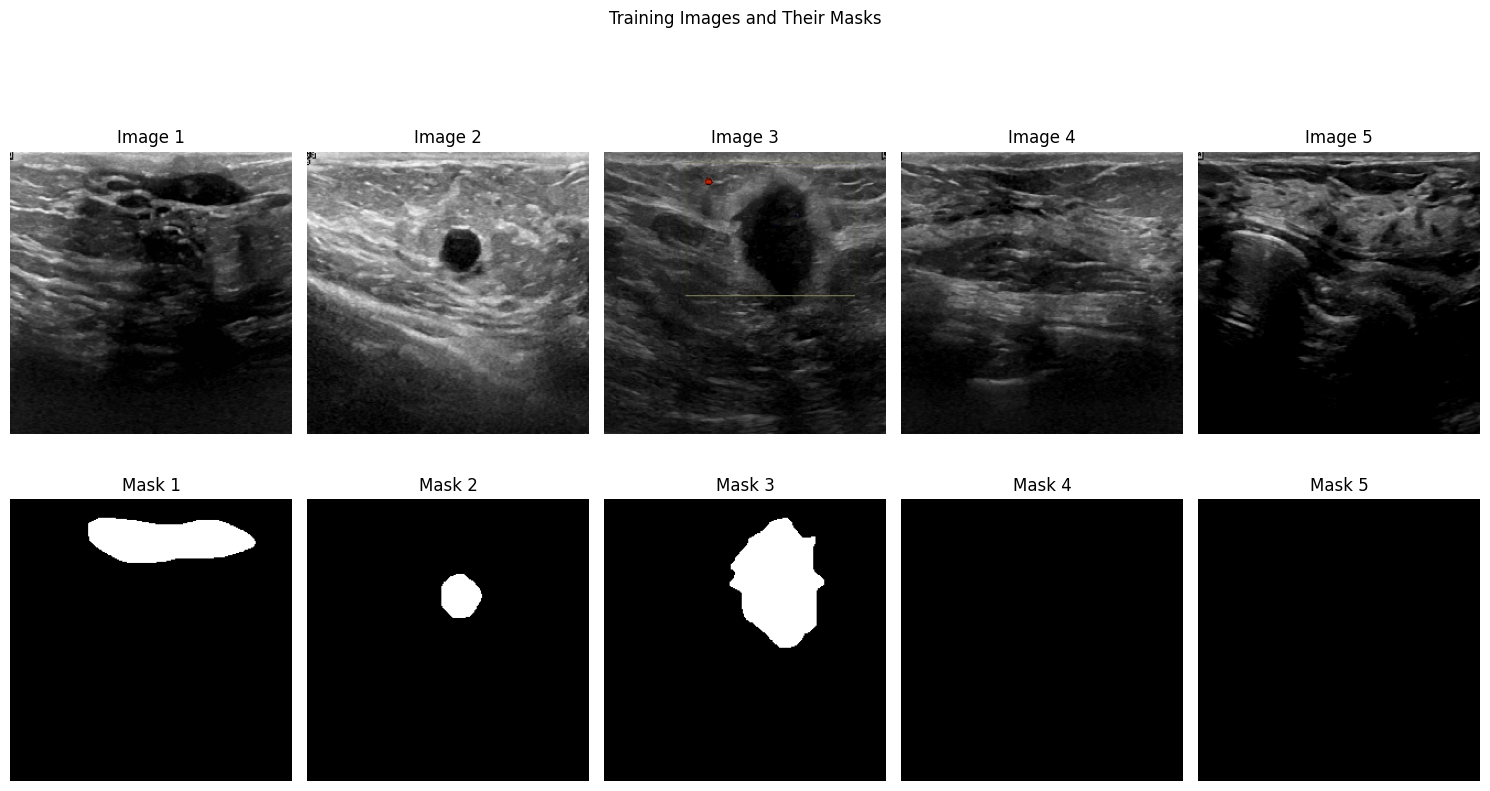

In [ ]:
for images, masks in train_ds.take(2):
    batch_size = images.shape[0]  # get how many images are in this batch

# Display images and masks
plt.figure(figsize=(15, 8))
for i in range(min(batch_size, 5)):  # show up to 5 images
    # Display image
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f"Image {i+1}")
    plt.axis('off')

    # Display corresponding mask
    plt.subplot(2, 5, i + 6)
    plt.imshow(masks[i].numpy().squeeze(), cmap='gray')

    plt.title(f"Mask {i+1}")
    plt.axis('off')

plt.suptitle("Training Images and Their Masks", y=1.05)
plt.tight_layout()
plt.show()

# Unet Model

Model Description:

In this project, we address the task of breast cancer image segmentation, where each image is paired with a corresponding mask image annotated into three classes: benign, malignant, and normal.

The model consists of:

Encoder blocks that progressively extract spatial features through convolution and max-pooling layers.

A bottleneck layer that captures deep feature representations.

Decoder blocks that upsample the feature maps and concatenate them with corresponding encoder features (skip connections) to preserve spatial context.

A final softmax-activated convolution layer to produce pixel-wise class probabilities for three classes.

The model is compiled using sparse categorical crossentropy (since the mask labels are integer-encoded: 0, 1, 2) and optimized with Adam optimizer. This architecture is specifically designed to effectively learn the spatial boundaries of each class within breast cancer images, ensuring accurate segmentation performance

In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, concatenate, add,Input,Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.layers import BatchNormalization,Activation
from tensorflow.keras.metrics import *
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dropout

In [ ]:
# Number of classes
NUM_CLASSES = 3

def dice_coefficient(y_true, y_pred, smooth=1):
    # Squeeze if needed
    y_true = tf.squeeze(y_true, axis=-1)  # Always squeeze last dimension

    # One-hot encode ground truth
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), NUM_CLASSES)  # (batch, 256, 256, 3)

    # Clip predictions
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

    # Compute intersection and union
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])

    dice = (2. * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice)  # mean over batch


# 🔥 U-Net building blocks
def conv_block(input, num_filters, dropout_rate=0.1):
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(input)
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
    if dropout_rate > 0.0:
        conv = Dropout(dropout_rate)(conv)
    return conv

def encoder_block(input, num_filters, dropout_rate=0.0):
    conv = conv_block(input, num_filters, dropout_rate)
    pool = MaxPooling2D((2, 2))(conv)
    return conv, pool

def decoder_block(input, skip_features, num_filters, dropout_rate=0.0):
    uconv = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    con = concatenate([uconv, skip_features])
    conv = conv_block(con, num_filters, dropout_rate)
    return conv

def build_model(input_shape, num_classes=3, dropout_rate=0.3):
    input_layer = Input(input_shape)

    s1, p1 = encoder_block(input_layer, 64, dropout_rate)
    s2, p2 = encoder_block(p1, 128, dropout_rate)
    s3, p3 = encoder_block(p2, 256, dropout_rate)
    s4, p4 = encoder_block(p3, 512, dropout_rate)

    b1 = conv_block(p4, 1024, dropout_rate)

    d1 = decoder_block(b1, s4, 512, dropout_rate)
    d2 = decoder_block(d1, s3, 256, dropout_rate)
    d3 = decoder_block(d2, s2, 128, dropout_rate)
    d4 = decoder_block(d3, s1, 64, dropout_rate)

    output_layer = Conv2D(num_classes, (1, 1), padding="same", activation="softmax")(d4)

    model = Model(input_layer, output_layer, name="U-Net")
    return model

# 🏗 Build and compile the model
unet = build_model(input_shape=(256, 256, 3), num_classes=3, dropout_rate=0.2)

# Use sparse categorical crossentropy for integer masks
unet.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="Adam",
    metrics=["accuracy", dice_coefficient]
)


Train on 100 ephocs and with batch size of 32

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

history = unet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop]
)


Epoch 1/50
30/30 [==============================] - 117s 2s/step - loss: 2.2596 - accuracy: 0.8893 - dice_coefficient: 0.6895 - val_loss: 0.4816 - val_accuracy: 0.9059 - val_dice_coefficient: 0.7965
Epoch 2/50
30/30 [==============================] - 33s 1s/step - loss: 0.3740 - accuracy: 0.9210 - dice_coefficient: 0.8249 - val_loss: 0.4594 - val_accuracy: 0.9059 - val_dice_coefficient: 0.8738
Epoch 3/50
30/30 [==============================] - 33s 1s/step - loss: 0.3437 - accuracy: 0.9212 - dice_coefficient: 0.8401 - val_loss: 0.3559 - val_accuracy: 0.9059 - val_dice_coefficient: 0.8520
Epoch 4/50
30/30 [==============================] - 33s 1s/step - loss: 0.2995 - accuracy: 0.9214 - dice_coefficient: 0.8574 - val_loss: 0.3229 - val_accuracy: 0.9059 - val_dice_coefficient: 0.8549
Epoch 5/50
30/30 [==============================] - 33s 1s/step - loss: 0.2808 - accuracy: 0.9214 - dice_coefficient: 0.8609 - val_loss: 0.3137 - val_accuracy: 0.9059 - val_dice_coefficient: 0.8619
Epoch 6/5

# Accuracy of Unet Model

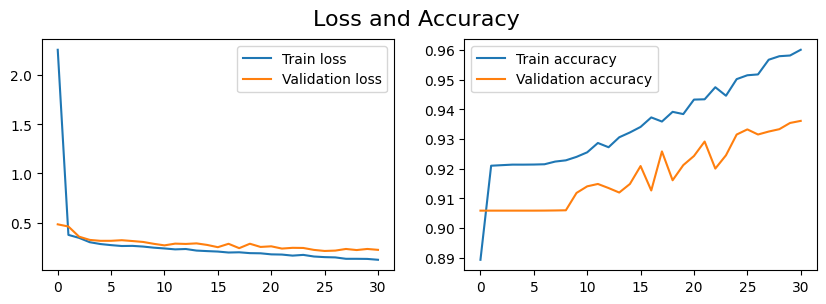

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()

# Prediction through Unet Model

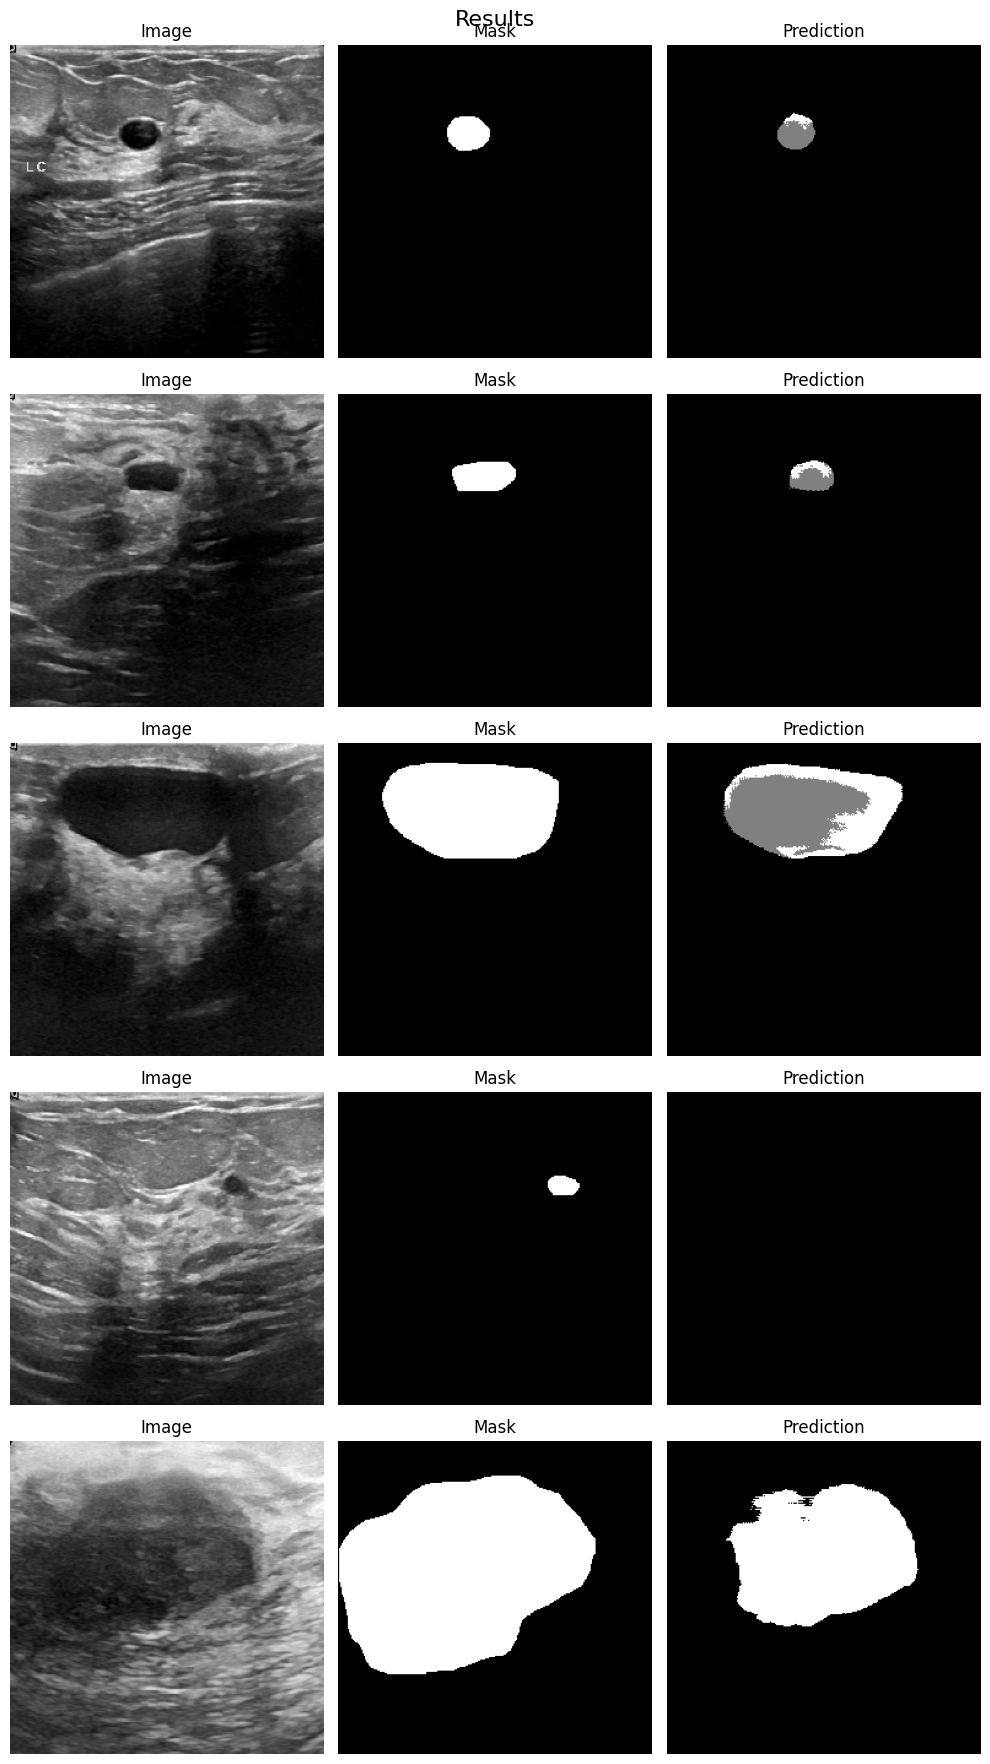

In [ ]:
for images, masks in val_ds.take(2):
    break

fig, ax = plt.subplots(5, 3, figsize=(10, 18))

j = np.random.randint(0, images.shape[0], 5)
for i in range(5):
    # Original Image
    ax[i, 0].imshow(np.squeeze(images[j[i]]), cmap='gray')
    ax[i, 0].set_title('Image')

    # Ground Truth Mask
    ax[i, 1].imshow(np.squeeze(masks[j[i]]), cmap='gray')
    ax[i, 1].set_title('Mask')

    # Prediction (argmax to get class indices)
    prediction = unet.predict(np.expand_dims(images[j[i]], 0), verbose=0)
    predicted_mask = np.argmax(prediction[0], axis=-1)   # <-- this converts softmax to class labels
    ax[i, 2].imshow(predicted_mask, cmap='gray')
    ax[i, 2].set_title('Prediction')

for a in ax.flatten():
    a.axis('off')

fig.suptitle('Results', fontsize=16)
plt.tight_layout()
plt.show()


**The model prediction is quite good but we can see that the model also predicting segmentation for normal classes, we need to handle this problem.**

# Evaltion Metrics of Unet Model

In [ ]:
# Accumulators
all_preds = []
all_masks = []

# Loop through the full validation dataset
for images, masks in val_ds:
    preds = unet.predict(images, verbose=0)
    preds_labels = np.argmax(preds, axis=-1)  # (batch_size, H, W)
    masks_labels = np.squeeze(masks, axis=-1)  # (batch_size, H, W)

    all_preds.append(preds_labels)
    all_masks.append(masks_labels)

# Stack everything to single arrays
all_preds = np.concatenate(all_preds, axis=0)
all_masks = np.concatenate(all_masks, axis=0)

# Compute Mean IoU
IOU_keras = MeanIoU(num_classes=3)
IOU_keras.update_state(all_masks, all_preds)
print("Mean IoU =", IOU_keras.result().numpy())

# Flatten for sklearn metrics
y_pred_flat = all_preds.flatten().astype(np.uint8)
y_true_flat = all_masks.flatten().astype(np.uint8)

# Compute precision, recall, F1, Dice (macro averaged)
p = precision_score(y_true_flat, y_pred_flat, average='macro')
r = recall_score(y_true_flat, y_pred_flat, average='macro')
f1 = f1_score(y_true_flat, y_pred_flat, average='macro')
dice = f1  # F1 = Dice in multiclass

print(f'Dice Score (macro) = {dice:.3f}')
print(f'Precision Score = {p:.3f}')
print(f'Recall Score = {r:.3f}')
print(f'F1 Score = {f1:.3f}')


Mean IoU = 0.49043247
Dice Score (macro) = 0.596
Precision Score = 0.812
Recall Score = 0.566
F1 Score = 0.596


In [ ]:
unet.save(r"C:\Users\drimr\Desktop\FYP Bachelors\FYP Ultrasound\Code and Data\unet.h5")

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()


# Unet Model Hyper Parameter Tuning

1. Add Early Stopping
Stop training when validation loss stops improving.good to prvent overfitting

2. Add Model Checkpointing
Save the best model based on validation IoU or loss.

3. Use Learning Rate Scheduler (ReduceLROnPlateau)
Reduce learning rate when a metric has stopped improving.

4. Batch Normalization
Between convolution and activation — improves convergence and stability. helps to bost traing speed and stability

5. batch size should be 16. 16 is a good balance for 256×256 images and stability

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Input, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.one_hot(tf.squeeze(tf.cast(y_true, tf.int32), axis=-1), 3)
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def conv_block(input, num_filters):
    conv = Conv2D(num_filters, (3, 3), padding="same", kernel_initializer='he_normal')(input)
    conv = BatchNormalization()(conv)
    conv = Activation("relu")(conv)
    conv = Conv2D(num_filters, (3, 3), padding="same", kernel_initializer='he_normal')(conv)
    conv = BatchNormalization()(conv)
    conv = Activation("relu")(conv)
    return conv


def encoder_block(input, num_filters):
    conv = conv_block(input, num_filters)
    pool = MaxPooling2D((2, 2))(conv)
    return conv, pool

def decoder_block(input, skip_features, num_filters):
    uconv = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    con = concatenate([uconv, skip_features])
    conv = conv_block(con, num_filters)
    return conv

def build_model(input_shape, num_classes=3):
    input_layer = Input(input_shape)

    s1, p1 = encoder_block(input_layer, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Final softmax for 3-class output per pixel
    output_layer = Conv2D(num_classes, (1, 1), padding="same", activation="softmax")(d4)

    model = Model(input_layer, output_layer, name="U-Net")
    return model

tuned_unet = build_model(input_shape=(256, 256, 3), num_classes=3)

# Use sparse_categorical_crossentropy because masks have integer class labels 0, 1, 2
tuned_unet.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", metrics=["accuracy",dice_coefficient])
#tuned_unet.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Callbacks
early_stop = EarlyStopping(
    monitor='val_dice_coefficient',
    patience=10,
    mode='max',  # <--- important
    restore_best_weights=True,
    verbose=1
)
# checkpoint = ModelCheckpoint('best_unet_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Train with callbacks
history = tuned_unet.fit(
    train_ds,
    epochs=50,
    validation_data = val_ds,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 170s 4s/step - accuracy: 0.8007 - dice_coefficient: 0.6397 - loss: 0.6280 - val_accuracy: 0.0386 - val_dice_coefficient: 0.0383 - val_loss: 234138.0781 - learning_rate: 0.0010
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9241 - dice_coefficient: 0.8496 - loss: 0.3074 - val_accuracy: 0.1575 - val_dice_coefficient: 0.1567 - val_loss: 173.7550 - learning_rate: 0.0010
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9227 - dice_coefficient: 0.8545 - loss: 0.3015 - val_accuracy: 0.0814 - val_dice_coefficient: 0.0754 - val_loss: 34.8998 - learning_rate: 0.0010
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9218 - dice_coefficient: 0.8538 - loss: 0.3036 - val_accuracy: 0.2940 - val_dice_coefficient: 0.2734 - val_loss: 3.2337 - learning_rate: 0.0010
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9226 - dice_coefficient: 0.8593 - loss: 0.2755 - val_accuracy: 0.0556 - val_dice_coefficient: 0

In [ ]:
tuned_unet.save(r"content/drive/MyDrive/newmodels/tuned_unet.h5")

# Accuracy of Tuned Unet Model

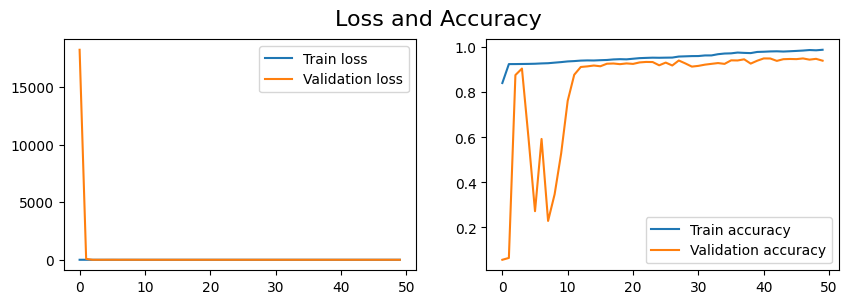

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()

**The training accuracy is 0.9607 and val accuracy is 0.9516 also training loss is 0.1049 and val loss is 0.1326**

- After tuning we can see that the model is now much generalize model. their less variance between the losses.

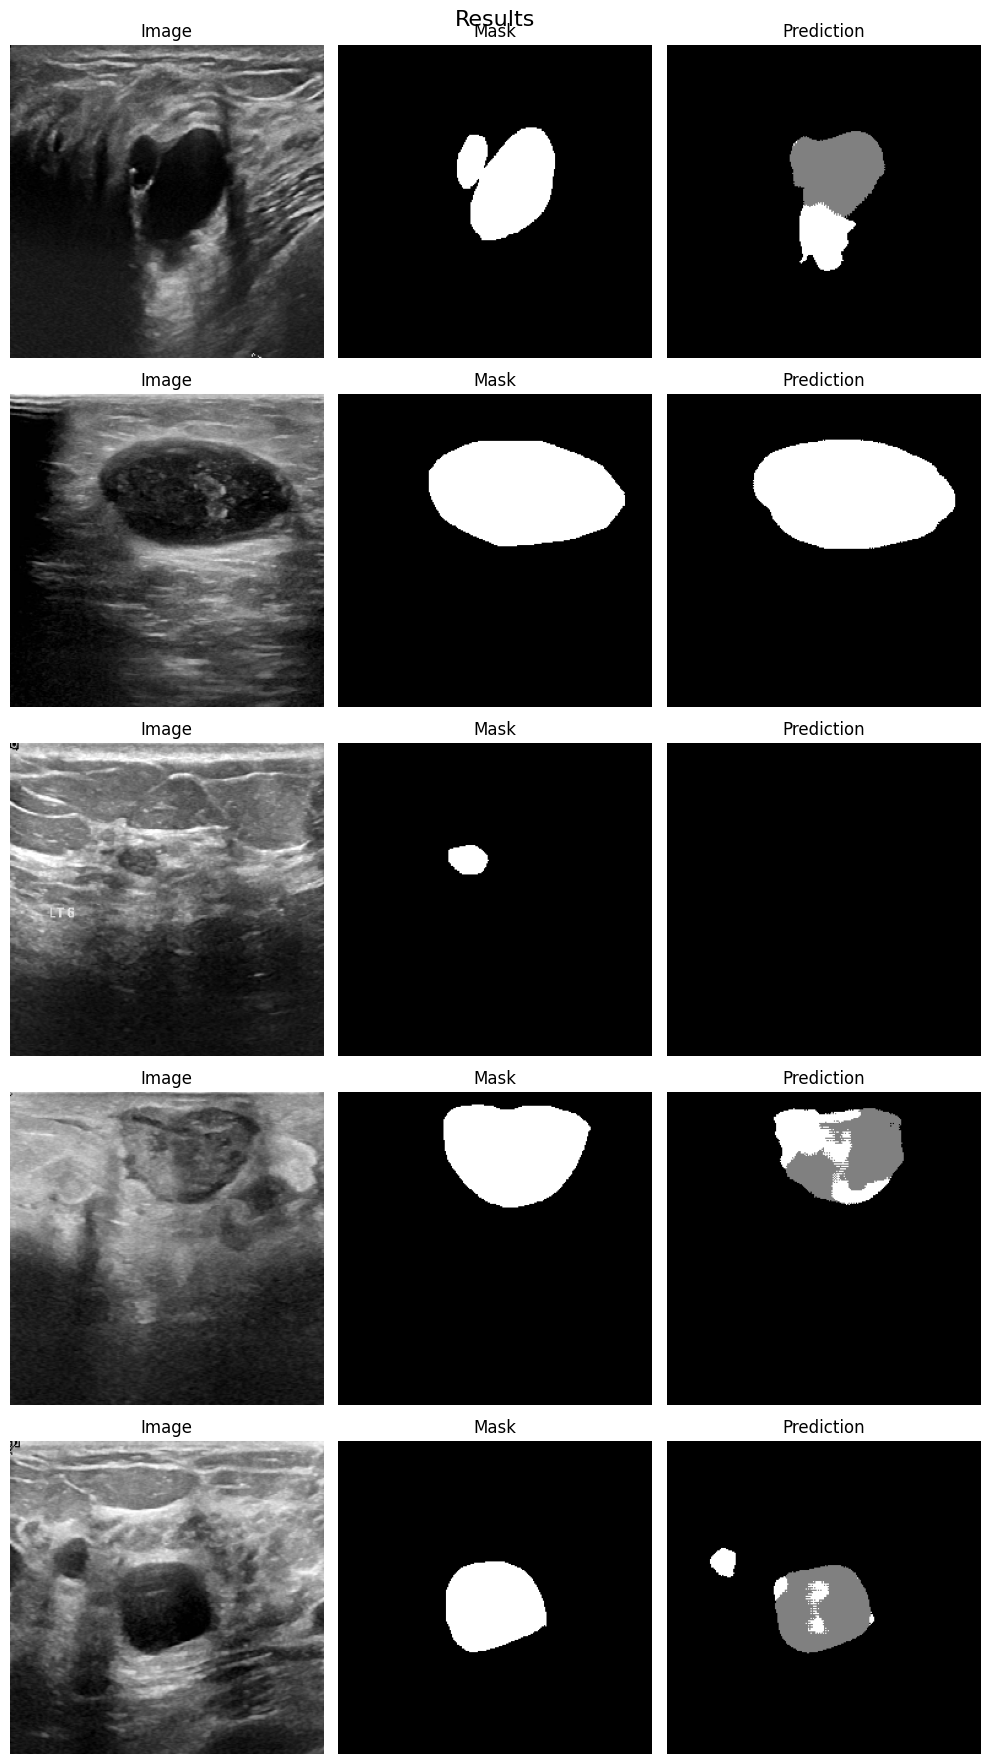

In [ ]:
for images, masks in val_ds.take(2):
    break

fig, ax = plt.subplots(5, 3, figsize=(10, 18))

j = np.random.randint(0, images.shape[0], 5)
for i in range(5):
    # Original Image
    ax[i, 0].imshow(np.squeeze(images[j[i]]), cmap='gray')
    ax[i, 0].set_title('Image')

    # Ground Truth Mask
    ax[i, 1].imshow(np.squeeze(masks[j[i]]), cmap='gray')
    ax[i, 1].set_title('Mask')

    # Prediction (argmax to get class indices)
    prediction = tuned_unet.predict(np.expand_dims(images[j[i]], 0), verbose=0)
    predicted_mask = np.argmax(prediction[0], axis=-1)   # <-- this converts softmax to class labels
    ax[i, 2].imshow(predicted_mask, cmap='gray')
    ax[i, 2].set_title('Prediction')

for a in ax.flatten():
    a.axis('off')

fig.suptitle('Results', fontsize=16)
plt.tight_layout()
plt.show()


Befor model was not able to predict normal classes correctly.
and now it is able to predict correct normal classes. our model now is much generalize model than before.

In [ ]:
# Accumulators
from tensorflow.keras.metrics import MeanIoU
from sklearn.metrics import precision_score, recall_score, f1_score
all_preds = []
all_masks = []

# Loop through the full validation dataset
for images, masks in val_ds:
    preds = tuned_unet.predict(images, verbose=0)
    preds_labels = np.argmax(preds, axis=-1)  # (batch_size, H, W)
    masks_labels = np.squeeze(masks, axis=-1)  # (batch_size, H, W)

    all_preds.append(preds_labels)
    all_masks.append(masks_labels)

# Stack everything to single arrays
all_preds = np.concatenate(all_preds, axis=0)
all_masks = np.concatenate(all_masks, axis=0)

# Compute Mean IoU
IOU_keras = MeanIoU(num_classes=3)
IOU_keras.update_state(all_masks, all_preds)
print("Mean IoU =", IOU_keras.result().numpy())

# Flatten for sklearn metrics
y_pred_flat = all_preds.flatten().astype(np.uint8)
y_true_flat = all_masks.flatten().astype(np.uint8)

# Compute precision, recall, F1, Dice (macro averaged)
p = precision_score(y_true_flat, y_pred_flat, average='macro')
r = recall_score(y_true_flat, y_pred_flat, average='macro')
f1 = f1_score(y_true_flat, y_pred_flat, average='macro')
dice = f1  # F1 = Dice in multiclass

print(f'Dice Score (macro) = {dice:.3f}')
print(f'Precision Score = {p:.3f}')
print(f'Recall Score = {r:.3f}')
print(f'F1 Score = {f1:.3f}')


Mean IoU = 0.5514782
Dice Score (macro) = 0.671
Precision Score = 0.814
Recall Score = 0.631
F1 Score = 0.671


# Transfer learning of U-Net

# Here’s how you can replace the encoder with a pretrained model (like VGG16) using Keras:(transfer learning in encoder)
Since U-Net is built of encoder (downsampling) and decoder (upsampling) parts — transfer learning is typically applied to the encoder part by replacing it with a pretrained model like VGG, ResNet, EfficientNet, etc. These are pretrained on large datasets (like ImageNet), and their feature extraction capabilities can be leveraged here.

Key Notes:
- I used VGG16 as a pretrained encoder.

- Replaced your custom encoder with VGG16’s convolutional feature maps.

- Frozen VGG16 layers for initial training (can unfreeze later for fine-tuning).

- Input shape must now be (256, 256, 3) because ImageNet pre-trained models expect 3 channels.

- Decoder and final segmentation output remain your custom design

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Input, add, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.one_hot(tf.squeeze(tf.cast(y_true, tf.int32), axis=-1), 3)
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

    dice = (2. * intersection + smooth) / (union + smooth)
    return dice


def conv_block(input, num_filters):
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(input)
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)

    return conv


def decoder_block(input, skip_features, num_filters):
    uconv = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    con = concatenate([uconv, skip_features])
    conv = conv_block(con, num_filters)
    return conv

def build_transfer_learning_unet(input_shape=(256, 256, 3), num_classes=3):
    # Load VGG16 pretrained model without top layers
    vgg = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    vgg.trainable = False  # Freeze VGG layers

    # Encoder: Using VGG16 feature maps
    s1 = vgg.get_layer("block1_conv2").output  # 256x256x64
    s2 = vgg.get_layer("block2_conv2").output  # 128x128x128
    s3 = vgg.get_layer("block3_conv3").output  # 64x64x256
    s4 = vgg.get_layer("block4_conv3").output  # 32x32x512

    b1 = vgg.get_layer("block5_conv3").output  # 16x16x512

    # Decoder: same as your original
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    output_layer = Conv2D(num_classes, (1, 1), padding="same", activation="softmax")(d4)

    model = Model(inputs=vgg.input, outputs=output_layer, name="TransferLearning_U-Net")
    return model

tl_unet = build_transfer_learning_unet(input_shape=(256, 256, 3), num_classes=3)

tl_unet.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", metrics=["accuracy", dice_coefficient])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_dice_coefficient',
    patience=10,
    restore_best_weights=True,
    mode='max'
)

# Fit the model
history = tl_unet.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=8,
    epochs=50,
    callbacks=[early_stop]
)


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 305s 7s/step - accuracy: 0.8033 - dice_coefficient: 0.7754 - loss: 1.1942 - val_accuracy: 0.9233 - val_dice_coefficient: 0.8814 - val_loss: 0.3356
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.9204 - dice_coefficient: 0.8585 - loss: 0.3195 - val_accuracy: 0.9242 - val_dice_coefficient: 0.8978 - val_loss: 0.2580
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9240 - dice_coefficient: 0.8862 - loss: 0.2411 - val_accuracy: 0.9279 - val_dice_coefficient: 0.9057 - val_loss: 0.2403
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9245 - dice_coefficient: 0.8896 - loss: 0.2385 - val_accuracy: 0.9237 - val_dice_coefficient: 0.9193 - val_loss: 0.2992
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9256 - dice_coefficient: 0.8972 - loss: 0.2362 - val_accuracy: 0.9333 - val_dice_coefficient: 0.9089 - val_loss: 0.2136
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9318 - dice_coe

In [ ]:
tl_unet.save(r"/content/drive/MyDrive/newmodels/tl_unet.h5")

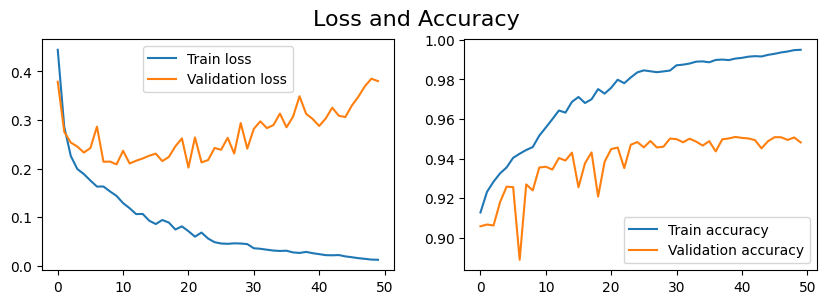

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()

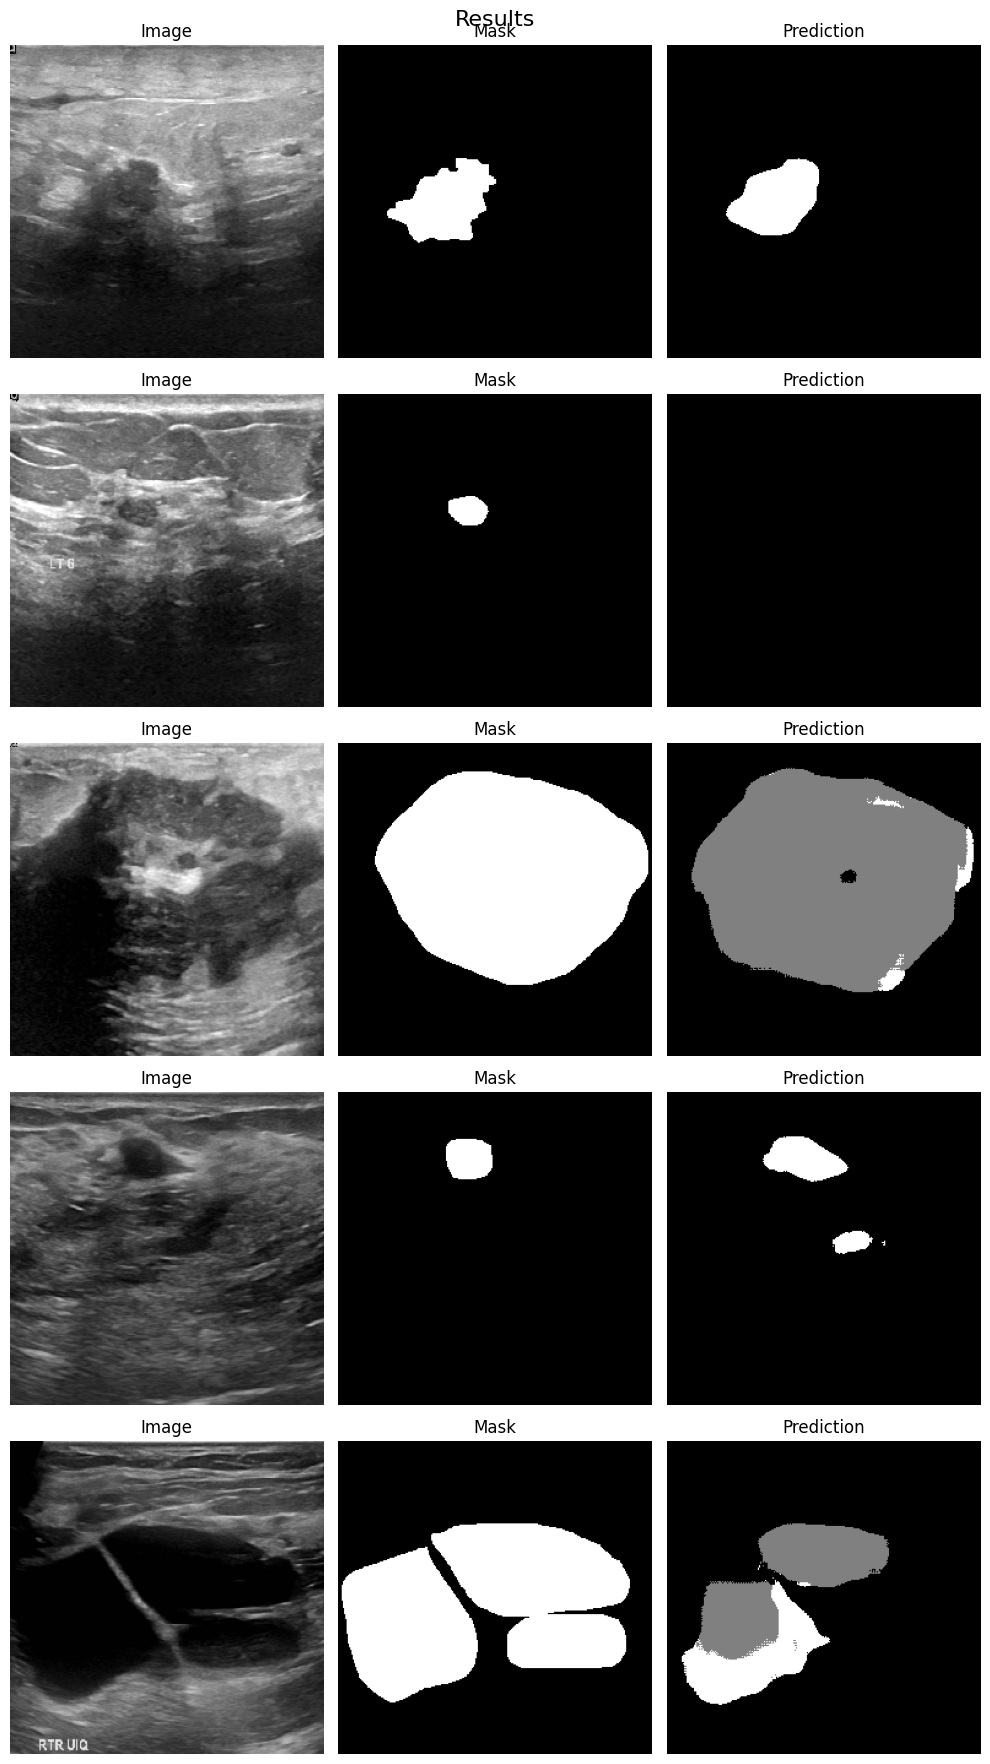

In [ ]:
for images, masks in val_ds.take(2):
    break

fig, ax = plt.subplots(5, 3, figsize=(10, 18))

j = np.random.randint(0, images.shape[0], 5)
for i in range(5):
    # Original Image
    ax[i, 0].imshow(np.squeeze(images[j[i]]), cmap='gray')
    ax[i, 0].set_title('Image')

    # Ground Truth Mask
    ax[i, 1].imshow(np.squeeze(masks[j[i]]), cmap='gray')
    ax[i, 1].set_title('Mask')

    # Prediction (argmax to get class indices)
    prediction = tl_unet.predict(np.expand_dims(images[j[i]], 0), verbose=0)
    predicted_mask = np.argmax(prediction[0], axis=-1)   # <-- this converts softmax to class labels
    ax[i, 2].imshow(predicted_mask, cmap='gray')
    ax[i, 2].set_title('Prediction')

for a in ax.flatten():
    a.axis('off')

fig.suptitle('Results', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.metrics import MeanIoU
import numpy as np

# Accumulate predictions and ground truths
all_preds = []
all_masks = []

# Predict and collect over entire test set
for images, masks in val_ds:
    preds = tl_unet.predict(images, verbose=0)
    preds_labels = np.argmax(preds, axis=-1)
    masks_labels = np.squeeze(masks)

    all_preds.append(preds_labels)
    all_masks.append(masks_labels)

# Concatenate all batches into one array
all_preds = np.concatenate(all_preds, axis=0)
all_masks = np.concatenate(all_masks, axis=0)

# Mean IoU
IOU_keras = MeanIoU(num_classes=3)
IOU_keras.update_state(all_masks, all_preds)
print("Mean IoU =", IOU_keras.result().numpy())

# Flatten for sklearn metrics
y_pred_flat = all_preds.flatten().astype(np.uint8)
y_true_flat = all_masks.flatten().astype(np.uint8)

# Precision, Recall, F1 (macro average)
p = precision_score(y_true_flat, y_pred_flat, average='macro')
r = recall_score(y_true_flat, y_pred_flat, average='macro')
f1 = f1_score(y_true_flat, y_pred_flat, average='macro')

# Dice Score (same as F1 macro for multiclass)
dice = f1_score(y_true_flat, y_pred_flat, average='macro')

print(f'Dice Score (macro) = {dice:.3f}')
print(f'Precision Score = {p:.3f}')
print(f'Recall Score = {r:.3f}')
print(f'F1 Score = {f1:.3f}')


Mean IoU = 0.64007896
Dice Score (macro) = 0.760
Precision Score = 0.811
Recall Score = 0.726
F1 Score = 0.760


# U2NET

U²-Net is originally in PyTorch, but their is no pretrained weights of model are avialble here.
and also there’s no official U²-Net in Keras.

it means we have to implement the u2net model architecture.

The U²-Net (as introduced in U²-Net: Going Deeper with Nested U-Structure for Salient Object Detection) is a nested U-shaped network inside each stage of the main U-shaped architecture — meaning:

Every stage (both encoder and decoder) contains a Residual U-block (RSU), which is itself a U-Net structure inside that block.

RSUs allow U²-Net to capture both local and global context efficiently by stacking these nested U structures.

In [ ]:
from tensorflow.keras.layers import Activation, UpSampling2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Input, add, Dropout, BatchNormalization

# Conv block with residuals and LeakyReLU
def conv_block(inputs, out_ch, rate=1):
    x = Conv2D(out_ch, 3, padding='same', dilation_rate=rate)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def RSU_L(inputs, out_ch, int_ch, num_layers, rate=2):
    x = conv_block(inputs, out_ch)
    init_feats = x
    x = conv_block(x, out_ch)

    # Encoder
    skip = []
    x = conv_block(x, int_ch)
    skip.append(x)

    for i in range(num_layers-2):
        x = MaxPooling2D((2,2))(x)
        x = conv_block(x, int_ch)
        skip.append(x)

    # Bridge
    x = conv_block(x, int_ch, rate=rate)

    # Decoder
    skip.reverse()
    x = concatenate([x, skip[0]])
    x = conv_block(x, int_ch)

    for i in range(num_layers-3):
        x = UpSampling2D((2,2), interpolation="bilinear")(x)
        x = concatenate([x, skip[i+1]])
        x = conv_block(x, int_ch)

    x = UpSampling2D((2,2), interpolation="bilinear")(x)
    x = concatenate([x, skip[-1]])
    x = conv_block(x, out_ch)

    # Add residual connection
    x = add([x, init_feats])

    return x

def RSU_4F(inputs, out_ch, int_ch):
    x0 = conv_block(inputs, out_ch, rate=1)

    # Encoder
    x1 = conv_block(x0, int_ch, rate=1)
    x2 = conv_block(x1, int_ch, rate=2)
    x3 = conv_block(x2, int_ch, rate=4)

    # Bridge
    x4 = conv_block(x3, int_ch, rate=8)

    # Decoder
    x = concatenate([x4, x3])
    x = conv_block(x, int_ch, rate=4)

    x = concatenate([x, x2])
    x = conv_block(x, int_ch, rate=2)

    x = concatenate([x, x1])
    x = conv_block(x, out_ch, rate=1)

    # Add residual connection
    x = add([x, x0])

    return x

def u2net(input_shape, out_ch, int_ch, num_classes=3):
    inputs = Input(input_shape)
    s0 = inputs

    s1 = RSU_L(s0, out_ch[0], int_ch[0], 7)
    p1 = MaxPooling2D((2,2))(s1)

    s2 = RSU_L(p1, out_ch[1], int_ch[1], 6)
    p2 = MaxPooling2D((2,2))(s2)

    s3 = RSU_L(p2, out_ch[2], int_ch[2], 5)
    p3 = MaxPooling2D((2,2))(s3)

    s4 = RSU_L(p3, out_ch[3], int_ch[3], 4)
    p4 = MaxPooling2D((2,2))(s4)

    s5 = RSU_L(p4, out_ch[4], int_ch[4], 3)
    p5 = MaxPooling2D((2,2))(s5)

    # Bridge
    b1 = RSU_4F(p5, out_ch[5], int_ch[5])
    b2 = UpSampling2D((2,2), interpolation="bilinear")(b1)

    # Decoder
    d1 = concatenate([b2, s5])
    d1 = RSU_4F(d1, out_ch[6], int_ch[6])
    u1 = UpSampling2D((2,2), interpolation="bilinear")(d1)

    d2 = concatenate([u1, s4])
    d2 = RSU_4F(d2, out_ch[7], int_ch[7])
    u2 = UpSampling2D((2,2), interpolation="bilinear")(d2)

    d3 = concatenate([u2, s3])
    d3 = RSU_4F(d3, out_ch[8], int_ch[8])
    u3 = UpSampling2D((2,2), interpolation="bilinear")(d3)

    d4 = concatenate([u3, s2])
    d4 = RSU_4F(d4, out_ch[9], int_ch[9])
    u4 = UpSampling2D((2,2), interpolation="bilinear")(d4)

    d5 = concatenate([u4, s1])
    d5 = RSU_4F(d5, out_ch[10], int_ch[10])
    u5 = UpSampling2D((2,2), interpolation="bilinear")(d5)

    # Side outputs
    y1 = Conv2D(num_classes, 3, padding="same")(d5)

    y2 = Conv2D(num_classes, 3, padding="same")(d4)
    y2 = UpSampling2D((2, 2), interpolation="bilinear")(y2)

    y3 = Conv2D(num_classes, 3, padding="same")(d3)
    y3 = UpSampling2D((4, 4), interpolation="bilinear")(y3)

    y4 = Conv2D(num_classes, 3, padding="same")(d2)
    y4 = UpSampling2D((8, 8), interpolation="bilinear")(y4)

    y5 = Conv2D(num_classes, 3, padding="same")(d1)
    y5 = UpSampling2D((16, 16), interpolation="bilinear")(y5)

    y6 = Conv2D(num_classes, 3, padding="same")(b1)
    y6 = UpSampling2D((32, 32), interpolation="bilinear")(y6)

    y0 = concatenate([y1, y2, y3, y4, y5, y6])
    y0 = Conv2D(num_classes, 3, padding="same")(y0)


    # Activation
    y0 = Activation('softmax')(y0)
    y1 = Activation('softmax')(y1)
    y2 = Activation('softmax')(y2)
    y3 = Activation('softmax')(y3)
    y4 = Activation('softmax')(y4)
    y5 = Activation('softmax')(y5)
    y6 = Activation('softmax')(y6)

    model = tf.keras.models.Model(inputs, [y0, y1, y2, y3, y4, y5, y6])
    return model

def build_u2net(input_shape=(256,256,3), num_classes=3):
    out_ch = [64, 64,64,64,64,64,64,64, 64, 64,64]
    int_ch = [16,16,16,16,16,16,16,16,16,16,16]

    model = u2net(input_shape, out_ch, int_ch, num_classes=num_classes)
    return model

if __name__ == "__main__":
    u2net = build_u2net()
    u2net.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_51[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 256, 256,  │     36,928 │ activation_18[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_52[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 256, 256,  │      9,232 │ activation_19[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_53[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 128, 128,  │          0 │ activation_20[0]… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 128, 128,  │      2,320 │ max_pooling2d_8[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_54[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 64, 64,    │          0 │ activation_21[0]… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 64, 64,    │      2,320 │ max_pooling2d_9[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │         64 │ conv2d_55[0][0] 

 Total params: 1,280,699 (4.89 MB)

 Trainable params: 1,274,811 (4.86 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Compile the model — same loss and metrics for each output
losses = {f'activation_{i}': 'categorical_crossentropy' for i in range(7)}
metrics = {f'activation_{i}': 'accuracy' for i in range(7)}

# Prepare supervised labels (deep supervision)
y_train_multi = [y_train] * 7
y_val_multi   = [y_val] * 7

# Compile the model (since you're using integer masks)
u2net.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=['sparse_categorical_crossentropy'] * 7,
    metrics=['accuracy'] * 7
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history = u2net.fit(
    x=X_train,
    y=y_train_multi,
    validation_data=(X_val, y_val_multi),
    epochs=50,
    batch_size=8,
    callbacks=[early_stop]
)


Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - activation_103_accuracy: 0.6372 - activation_103_loss: 0.8655 - activation_104_accuracy: 0.5900 - activation_104_loss: 1.0088 - activation_105_accuracy: 0.8711 - activation_105_loss: 0.5151 - activation_106_accuracy: 0.4395 - activation_106_loss: 1.2557 - activation_107_accuracy: 0.2452 - activation_107_loss: 2.0347 - activation_108_accuracy: 0.8684 - activation_108_loss: 0.5532 - activation_109_accuracy: 0.3283 - activation_109_loss: 1.5252 - loss: 7.7582 - val_activation_103_accuracy: 0.9240 - val_activation_103_loss: 0.5074 - val_activation_104_accuracy: 0.9233 - val_activation_104_loss: 0.5228 - val_activation_105_accuracy: 0.9244 - val_activation_105_loss: 0.5105 - val_activation_106_accuracy: 0.9243 - val_activation_106_loss: 0.6243 - val_activation_107_accuracy: 0.9094 - val_activation_107_loss: 0.6812 - val_activation_108_accuracy: 0.9244 - val_activation_108_loss: 0.4278 - val_activation_109_accuracy: 0.9194 - val_activation

In [ ]:
u2net.save(r"/content/drive/MyDrive/VIRUS/U2Net")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(history.history.keys())


dict_keys(['activation_103_accuracy', 'activation_103_loss', 'activation_104_accuracy', 'activation_104_loss', 'activation_105_accuracy', 'activation_105_loss', 'activation_106_accuracy', 'activation_106_loss', 'activation_107_accuracy', 'activation_107_loss', 'activation_108_accuracy', 'activation_108_loss', 'activation_109_accuracy', 'activation_109_loss', 'loss', 'val_activation_103_accuracy', 'val_activation_103_loss', 'val_activation_104_accuracy', 'val_activation_104_loss', 'val_activation_105_accuracy', 'val_activation_105_loss', 'val_activation_106_accuracy', 'val_activation_106_loss', 'val_activation_107_accuracy', 'val_activation_107_loss', 'val_activation_108_accuracy', 'val_activation_108_loss', 'val_activation_109_accuracy', 'val_activation_109_loss', 'val_loss'])


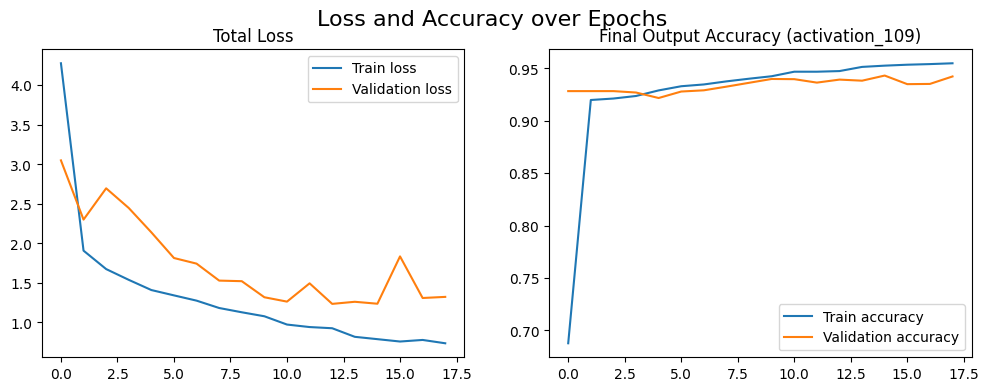

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[0].set_title("Total Loss")

# Accuracy plot — for final output 'activation_109'
ax[1].plot(history.epoch, history.history["activation_109_accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_activation_109_accuracy"], label="Validation accuracy")
ax[1].legend()
ax[1].set_title("Final Output Accuracy (activation_109)")

fig.suptitle('Loss and Accuracy over Epochs', fontsize=16)
plt.show()



# Prediction with u2net

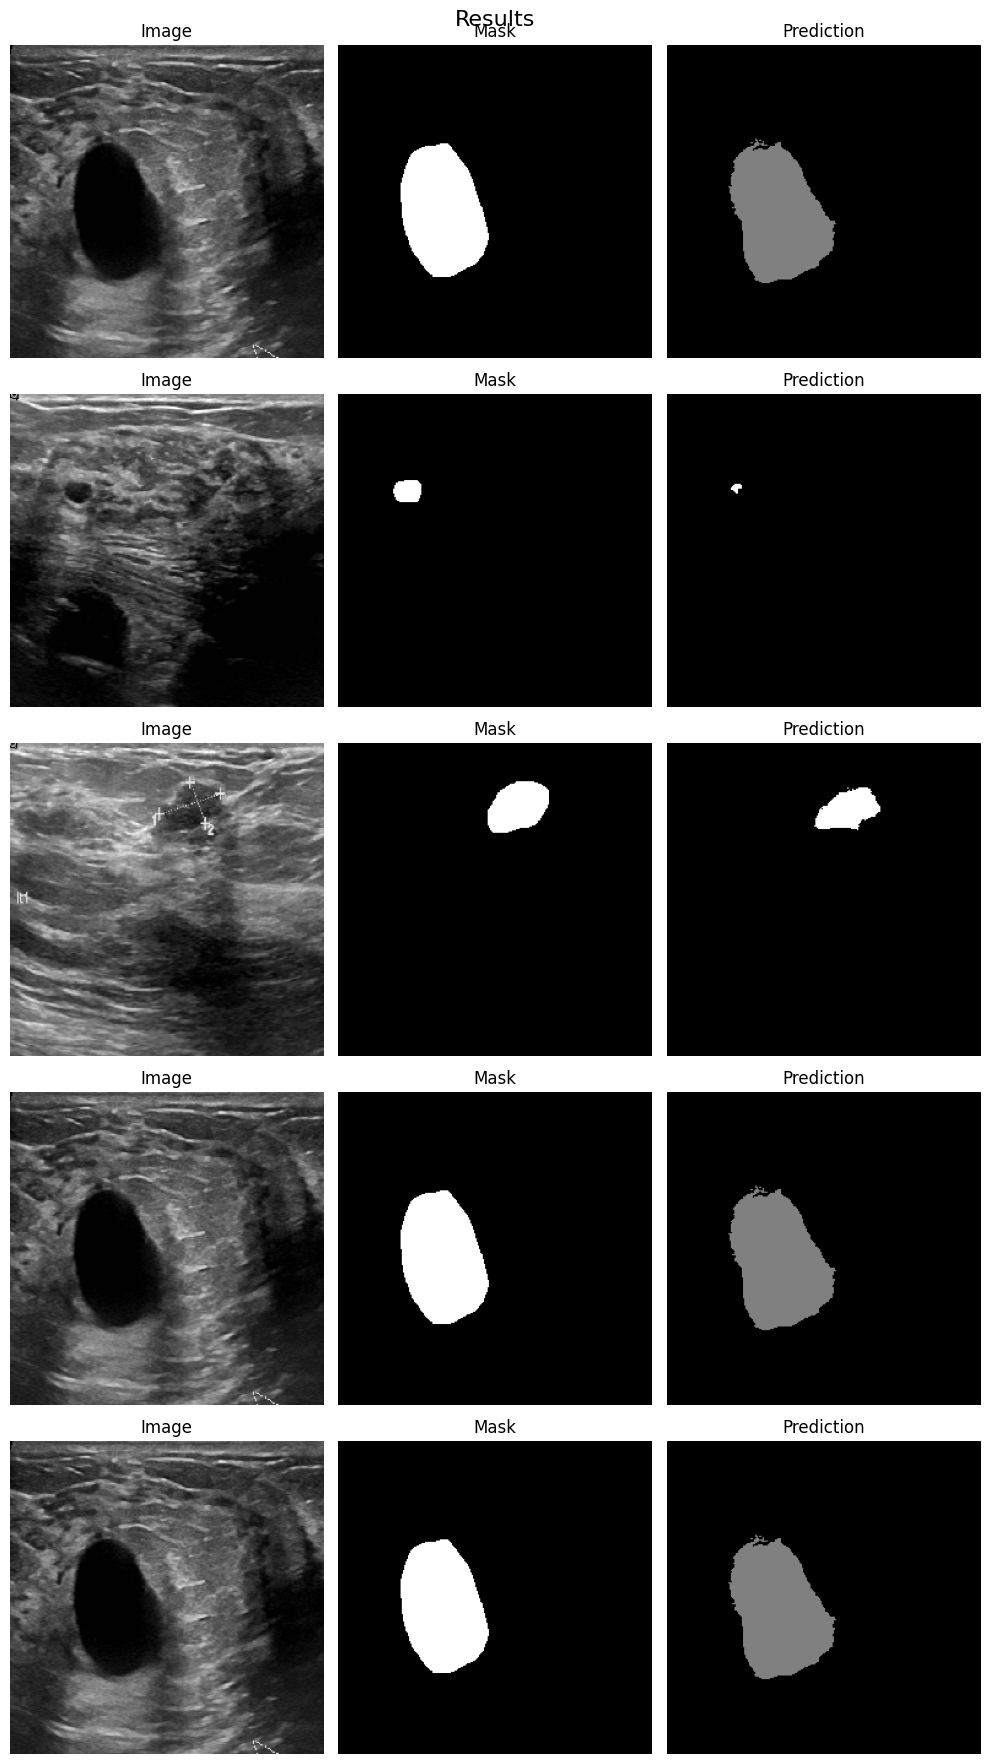

In [ ]:
for images, masks in val_ds.take(2):
    break

fig, ax = plt.subplots(5, 3, figsize=(10, 18))

j = np.random.randint(0, images.shape[0], 5)
for i in range(5):
    # Original Image
    ax[i, 0].imshow(np.squeeze(images[j[i]]), cmap='gray')
    ax[i, 0].set_title('Image')

    # Ground Truth Mask
    ax[i, 1].imshow(np.squeeze(masks[j[i]]), cmap='gray')
    ax[i, 1].set_title('Mask')

    # Prediction (argmax to get class indices)
    prediction = u2net.predict(np.expand_dims(images[j[i]], 0), verbose=0)
    predicted_mask = np.argmax(prediction[0], axis=-1)   # <-- this converts softmax to class labels
    ax[i, 2].imshow(np.squeeze(predicted_mask), cmap='gray')  # <-- Squeeze to remove the extra dimension
    ax[i, 2].set_title('Prediction')

for a in ax.flatten():
    a.axis('off')

fig.suptitle('Results', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.metrics import MeanIoU
from sklearn.metrics import precision_score, recall_score, f1_score
all_preds = []
all_masks = []

for images, masks in val_ds:
    y_pred = u2net.predict(images, verbose=0)
    y_pred_final = y_pred[-1]  # Final output

    y_pred_labels = np.argmax(y_pred_final, axis=-1)   # (batch, 256, 256)
    y_test_labels = np.squeeze(masks, axis=-1)         # (batch, 256, 256)

    # Ensure shapes match before stacking
    assert y_pred_labels.shape == y_test_labels.shape, f"Shape mismatch: {y_pred_labels.shape} vs {y_test_labels.shape}"

    all_preds.append(y_pred_labels)
    all_masks.append(y_test_labels)

# Concatenate
all_preds = np.concatenate(all_preds, axis=0)
all_masks = np.concatenate(all_masks, axis=0)

# Mean IoU
IOU_keras = MeanIoU(num_classes=3)
IOU_keras.update_state(all_masks, all_preds)
print("Mean IoU =", IOU_keras.result().numpy())

# Flatten for sklearn metrics
y_pred_flat = all_preds.flatten().astype(np.uint8)
y_true_flat = all_masks.flatten().astype(np.uint8)

# Precision, Recall, F1 (macro average)
p = precision_score(y_true_flat, y_pred_flat, average='macro')
r = recall_score(y_true_flat, y_pred_flat, average='macro')
f1 = f1_score(y_true_flat, y_pred_flat, average='macro')

# Dice Score (same as F1 macro for multiclass)
dice = f1_score(y_true_flat, y_pred_flat, average='macro')

print(f'Dice Score (macro) = {dice:.3f}')
print(f'Precision Score = {p:.3f}')
print(f'Recall Score = {r:.3f}')
print(f'F1 Score = {f1:.3f}')

print('Pred shape:', all_preds.shape)
print('GT shape:', all_masks.shape)

Mean IoU = 0.4220182
Dice Score (macro) = 0.506
Precision Score = 0.767
Recall Score = 0.452
F1 Score = 0.506
Pred shape: (155, 256, 256)
GT shape: (155, 256, 256)


**Our dataset is less and noisy**

U-Net tends to generalize better on limited or noisy datasets
— because it’s simpler, has fewer parameters, and is less likely to overfit. It focuses on capturing the core spatial features without getting distracted by noise.

U²-Net, especially the full version, shines on large, diverse, or high-detail datasets
— where its nested U-structures and multi-scale supervision can capture finer, more complex patterns. But on limited/noisy data, its extra complexity can actually hurt generalization, making it prone to overfitting

# DeepLabV3+ Replication with MobileNetV2 Backbone (Keras)


This implementation replicates the DeepLabV3+ architecture using TensorFlow Keras, with MobileNetV2 as the backbone for feature extraction. It's customized for semantic segmentation tasks with support for arbitrary number of classes (default is 4).



In [ ]:
!git clone --depth 1 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 4351, done.
remote: Counting objects: 100% (4351/4351), done.
remote: Compressing objects: 100% (3261/3261), done.
remote: Total 4351 (delta 1171), reused 2921 (delta 1017), pack-reused 0 (from 0)
Receiving objects: 100% (4351/4351), 53.73 MiB | 31.22 MiB/s, done.
Resolving deltas: 100% (1171/1171), done.


In [ ]:
!pip install -q tf-slim

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def DeepLabV3Plus(num_classes=4, input_shape=(224, 224, 3)):
    # Use the recommended input shape to load the pretrained weights properly.
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Get the high-level feature map from the last layer of the bottleneck.
    high_level_feature = base_model.get_layer('block_13_expand_relu').output  # Expected shape: (14, 14, 576)
    # Apply a convolution (ASPP-like) to adjust the number of filters.
    x = layers.Conv2D(256, 3, padding="same", dilation_rate=6, activation='relu')(high_level_feature)
    x = layers.BatchNormalization()(x)

    # Upsample high-level features from 14x14 to 56x56 (scale factor 4)
    x = layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(x)  # Now shape: (56,56,256)

    # Get low-level features from an earlier layer.
    low_level_feature = base_model.get_layer('block_3_expand_relu').output   # Expected shape: (56, 56, 144)
    low_level_feature = layers.Conv2D(48, 1, padding="same", activation='relu')(low_level_feature)
    low_level_feature = layers.BatchNormalization()(low_level_feature)

    # Now both tensors are (56,56) spatially—concatenate along the channel dimension.
    x = layers.Concatenate()([x, low_level_feature])  # Shape becomes (56, 56, 256+48 = 304)

    # Decoder: refine the features with a couple of conv layers.
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Upsample the features back to the input spatial resolution (224x224)
    x = layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(x)  # (56*4 = 224)

    # Final 1x1 conv layer to produce segmentation logits
    outputs = layers.Conv2D(num_classes, kernel_size=1, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
    return model



# Compilation

In [ ]:
NUM_CLASSES = 3
deepLab = DeepLabV3Plus(num_classes=NUM_CLASSES + 1, input_shape=(256, 256, 3))

deepLab.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# deepLab.summary()

<ipython-input-28-efddd59149e6>:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = deepLab.fit(train_ds, validation_data=val_ds, epochs=50,callbacks=[early_stop])

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.3602 - loss: 1.5809 - val_accuracy: 0.1847 - val_loss: 1.4306
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 728ms/step - accuracy: 0.7900 - loss: 1.0451 - val_accuracy: 0.7500 - val_loss: 1.1706
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 773ms/step - accuracy: 0.9303 - loss: 0.6302 - val_accuracy: 0.8808 - val_loss: 0.7220
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 764ms/step - accuracy: 0.9509 - loss: 0.4784 - val_accuracy: 0.9155 - val_loss: 0.5112
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 723ms/step - accuracy: 0.9578 - loss: 0.4088 - val_accuracy: 0.9252 - val_loss: 0.4020
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 727ms/step - accuracy: 0.9660 - loss: 0.3324 - val_accuracy: 0.9257 - val_loss: 0.3580
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 729ms/step - accuracy: 0.9711 - loss: 0.2534 - val_accuracy: 0.9253 - val_loss: 0.3493
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 724ms/step - accuracy: 0.9741 - loss: 0.2311 - val_accura

In [ ]:
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# history = deepLab.fit(train_ds, validation_data=val_ds, epochs=50,callbacks=[early_stop])

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.3592 - loss: 1.5942 - val_accuracy: 0.9067 - val_loss: 0.9861
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 378ms/step - accuracy: 0.7920 - loss: 1.0507 - val_accuracy: 0.8749 - val_loss: 0.7967
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 380ms/step - accuracy: 0.9286 - loss: 0.6020 - val_accuracy: 0.8818 - val_loss: 0.6078
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 380ms/step - accuracy: 0.9433 - loss: 0.4239 - val_accuracy: 0.9050 - val_loss: 0.4779
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 380ms/step - accuracy: 0.9546 - loss: 0.3236 - val_accuracy: 0.9126 - val_loss: 0.4271
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 378ms/step - accuracy: 0.9593 - loss: 0.2749 - val_accuracy: 0.9150 - val_loss: 0.3927
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 378ms/step - accuracy: 0.9646 - loss: 0.2420 - val_accuracy: 0.9153 - val_loss: 0.3732
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 377ms/step - accuracy: 0.9688 - loss: 0.2025 - val_accura

In [ ]:
deepLab.save(r"C:\Users\drimr\Desktop\FYP Bachelors\FYP Ultrasound\Code and Data\deepLab.h5")

In [ ]:
loss, acc = deepLab.evaluate(val_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {acc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - accuracy: 0.9308 - loss: 0.3152
Validation Loss: 0.3357
Validation Accuracy: 0.9259


# Visualizing results

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


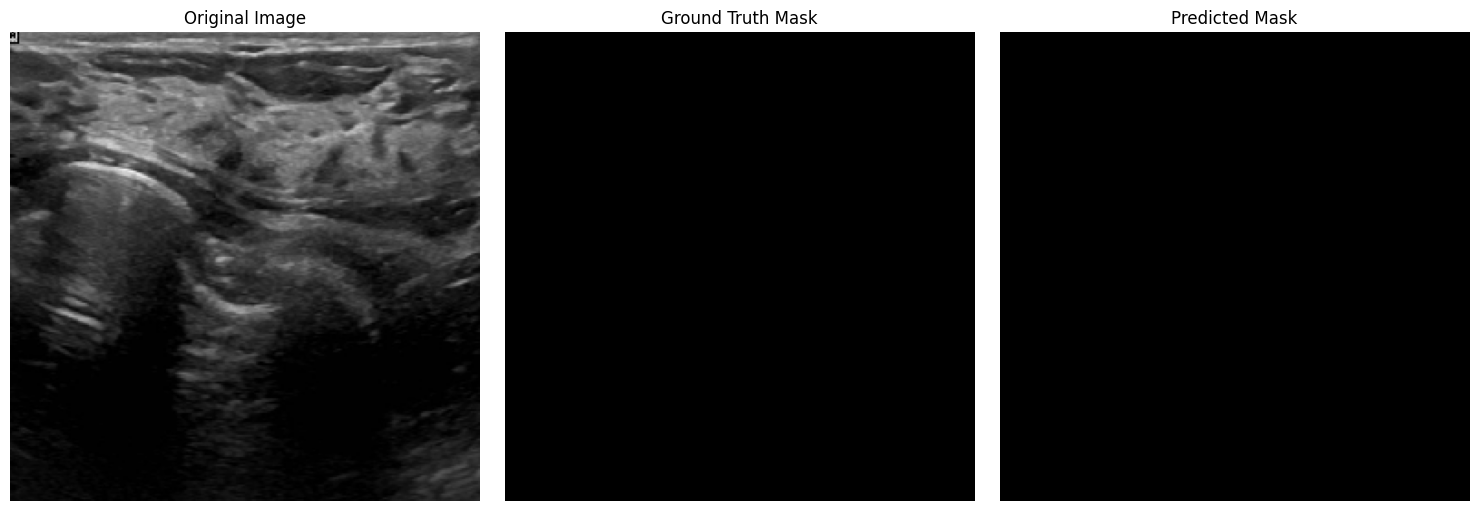

In [ ]:
import matplotlib.pyplot as plt

# Get one sample from the validation set
for image, true_mask in val_ds.take(1):
    break

# Predict the mask
pred = deepLab.predict(tf.expand_dims(image[0], axis=0))  # Add batch
pred_mask = tf.argmax(pred[0], axis=-1)              # Remove batch, get class per pixel
pred_mask = tf.expand_dims(pred_mask, axis=-1)       # For visualization

# Plotting everything
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image[0])
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(true_mask[0], cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.tight_layout()
plt.show()


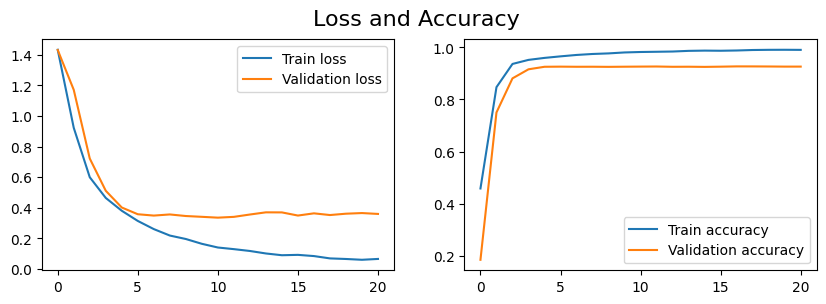

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()

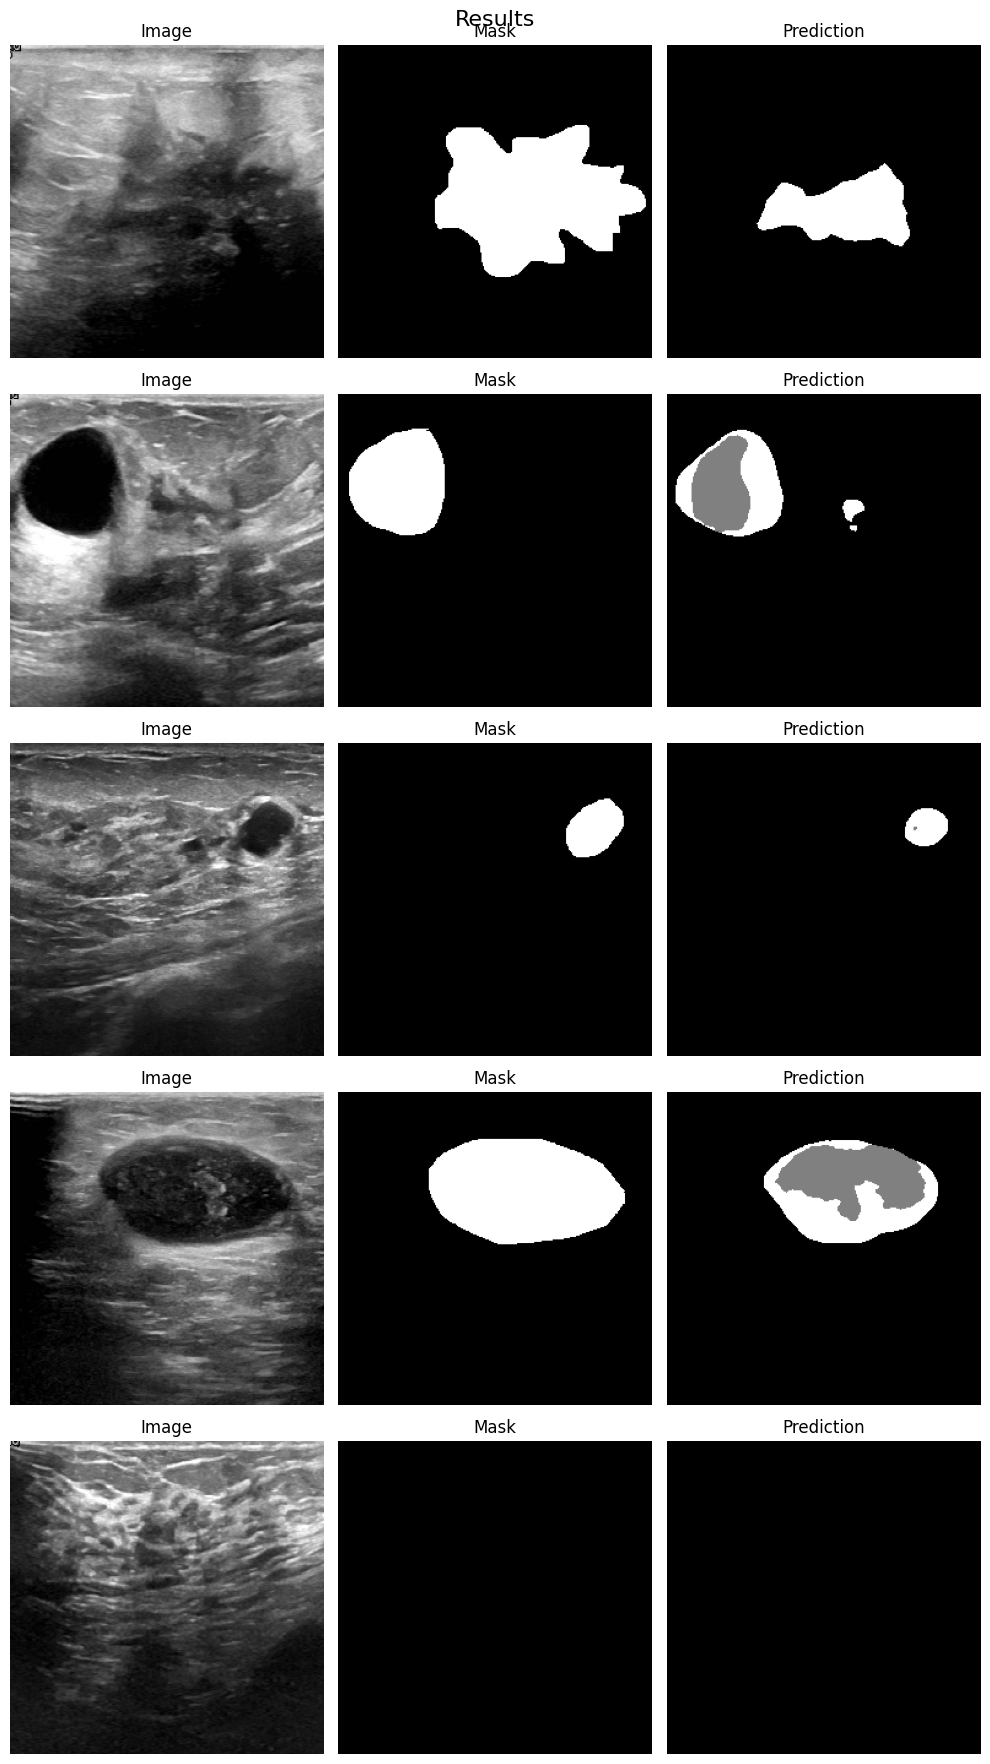

In [ ]:
for images, masks in val_ds.take(2):
    break

fig, ax = plt.subplots(5, 3, figsize=(10, 18))

j = np.random.randint(0, images.shape[0], 5)
for i in range(5):
    # Original Image
    ax[i, 0].imshow(np.squeeze(images[j[i]]), cmap='gray')
    ax[i, 0].set_title('Image')

    # Ground Truth Mask
    ax[i, 1].imshow(np.squeeze(masks[j[i]]), cmap='gray')
    ax[i, 1].set_title('Mask')

    # Prediction (argmax to get class indices)
    prediction = deepLab.predict(np.expand_dims(images[j[i]], 0), verbose=0)
    predicted_mask = np.argmax(prediction[0], axis=-1)   # <-- this converts softmax to class labels
    ax[i, 2].imshow(np.squeeze(predicted_mask), cmap='gray')  # <-- Squeeze to remove the extra dimension
    ax[i, 2].set_title('Prediction')

for a in ax.flatten():
    a.axis('off')

fig.suptitle('Results', fontsize=16)
plt.tight_layout()
plt.show()


# Scores / Evaluation Metrics

In [ ]:
# Accumulators
from tensorflow.keras.metrics import MeanIoU
from sklearn.metrics import precision_score, recall_score, f1_score
all_preds = []
all_masks = []

# Loop through the full validation dataset
for images, masks in val_ds:
    preds = deepLab.predict(images, verbose=0)
    preds_labels = np.argmax(preds, axis=-1)  # (batch_size, H, W)
    masks_labels = np.squeeze(masks, axis=-1)  # (batch_size, H, W)

    all_preds.append(preds_labels)
    all_masks.append(masks_labels)

# Stack everything to single arrays
all_preds = np.concatenate(all_preds, axis=0)
all_masks = np.concatenate(all_masks, axis=0)

# Compute Mean IoU
IOU_keras = MeanIoU(num_classes=3)
IOU_keras.update_state(all_masks, all_preds)
print("Mean IoU =", IOU_keras.result().numpy())

# Flatten for sklearn metrics
y_pred_flat = all_preds.flatten().astype(np.uint8)
y_true_flat = all_masks.flatten().astype(np.uint8)

# Compute precision, recall, F1, Dice (macro averaged)
p = precision_score(y_true_flat, y_pred_flat, average='macro')
r = recall_score(y_true_flat, y_pred_flat, average='macro')
f1 = f1_score(y_true_flat, y_pred_flat, average='macro')
dice = f1  # F1 = Dice in multiclass

print(f'Dice Score (macro) = {dice:.3f}')
print(f'Precision Score = {p:.3f}')
print(f'Recall Score = {r:.3f}')
print(f'F1 Score = {f1:.3f}')


Mean IoU = 0.3317634
Dice Score (macro) = 0.364
Precision Score = 0.750
Recall Score = 0.357
F1 Score = 0.364


# SegNet Architecture in Keras

This is a custom Keras implementation of the SegNet architecture—a fully convolutional encoder-decoder network designed for semantic segmentation. It’s particularly effective for pixel-wise labeling tasks and works well with relatively small datasets thanks to its simpler structure compared to other modern architectures like DeepLab.



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def SegNet(input_shape=(256, 256, 3), num_classes=4):  # 3 classes + background
    inputs = layers.Input(shape=input_shape)

    # ---------- Encoder ----------
    # Block 1
    x = layers.Conv2D(64, 3, padding="same", activation='relu')(inputs)
    x = layers.Conv2D(64, 3, padding="same", activation='relu')(x)
    x = layers.MaxPooling2D()(x)  # 128x128

    # Block 2
    x = layers.Conv2D(128, 3, padding="same", activation='relu')(x)
    x = layers.Conv2D(128, 3, padding="same", activation='relu')(x)
    x = layers.MaxPooling2D()(x)  # 64x64

    # Block 3
    x = layers.Conv2D(256, 3, padding="same", activation='relu')(x)
    x = layers.Conv2D(256, 3, padding="same", activation='relu')(x)
    x = layers.MaxPooling2D()(x)  # 32x32

    # ---------- Decoder ----------
    # Block 3
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(256, 3, padding="same", activation='relu')(x)
    x = layers.Conv2D(256, 3, padding="same", activation='relu')(x)

    # Block 2
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(128, 3, padding="same", activation='relu')(x)
    x = layers.Conv2D(128, 3, padding="same", activation='relu')(x)

    # Block 1
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation='relu')(x)
    x = layers.Conv2D(64, 3, padding="same", activation='relu')(x)

    # Final segmentation layer
    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(x)

    return models.Model(inputs, outputs)


# Models summary + Compilation

In [ ]:
segnet = SegNet(input_shape=(256, 256, 3), num_classes=4)  # assuming you remapped masks
segnet.compile(tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
segnet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 128)  │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 256, 256, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 256, 256, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 256, 256, 4)    │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,879,172 (10.98 MB)

 Trainable params: 2,879,172 (10.98 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
segnet.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stop])

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 176s 4s/step - accuracy: 0.8105 - loss: 1.0452 - val_accuracy: 0.9233 - val_loss: 0.4462
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9228 - loss: 0.3988 - val_accuracy: 0.9233 - val_loss: 0.3361
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9219 - loss: 0.3272 - val_accuracy: 0.9233 - val_loss: 0.3145
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9214 - loss: 0.3087 - val_accuracy: 0.9233 - val_loss: 0.3041
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9213 - loss: 0.3016 - val_accuracy: 0.9233 - val_loss: 0.3157
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9218 - loss: 0.2971 - val_accuracy: 0.9233 - val_loss: 0.2894
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9222 - loss: 0.2853 - val_accuracy: 0.9233 - val_loss: 0.2831
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9259 - loss: 0.2734 - val_accuracy: 0.9233 - val_loss

In [ ]:
segnet.save(r"C:\Users\drimr\Desktop\FYP Bachelors\FYP Ultrasound\Code and Data\segnet.h5")

In [ ]:
loss, acc = segnet.evaluate(val_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {acc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 332ms/step - accuracy: 0.9396 - loss: 0.1950
Validation Loss: 0.2133
Validation Accuracy: 0.9343


# Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


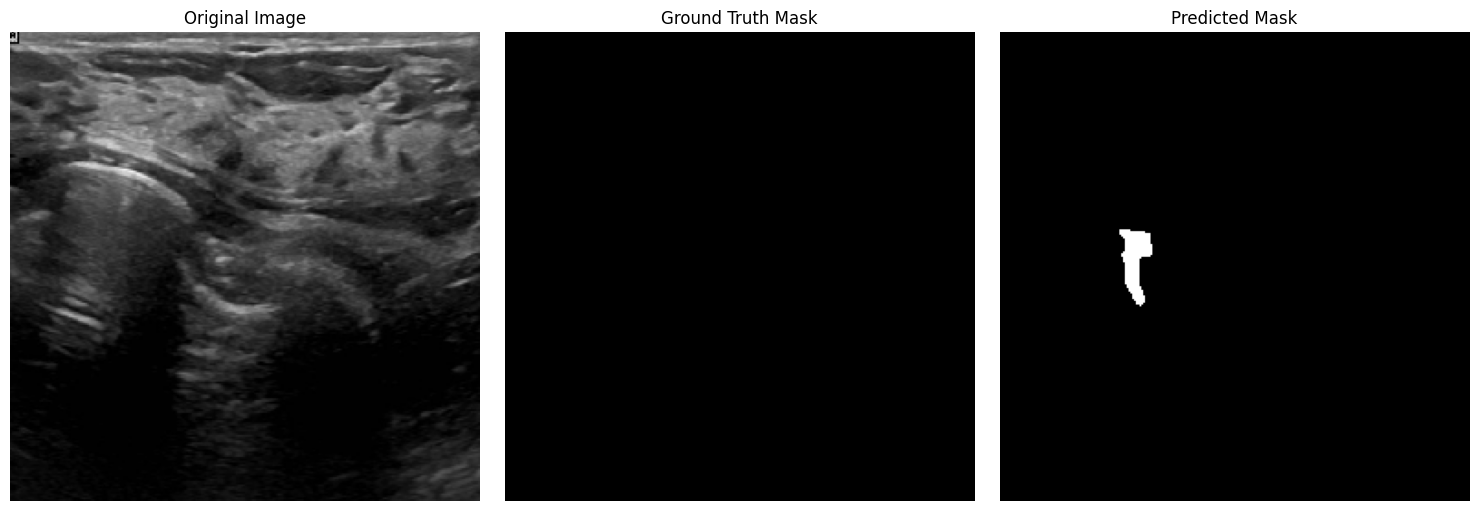

In [ ]:
import matplotlib.pyplot as plt

# Get one sample from the validation set
for image, true_mask in val_ds.take(1):
    break

# Predict the mask
pred = segnet.predict(tf.expand_dims(image[0], axis=0))  # Add batch
pred_mask = tf.argmax(pred[0], axis=-1)              # Remove batch, get class per pixel
pred_mask = tf.expand_dims(pred_mask, axis=-1)       # For visualization

# Plotting everything
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image[0])
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(true_mask[0], cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.tight_layout()
plt.show()


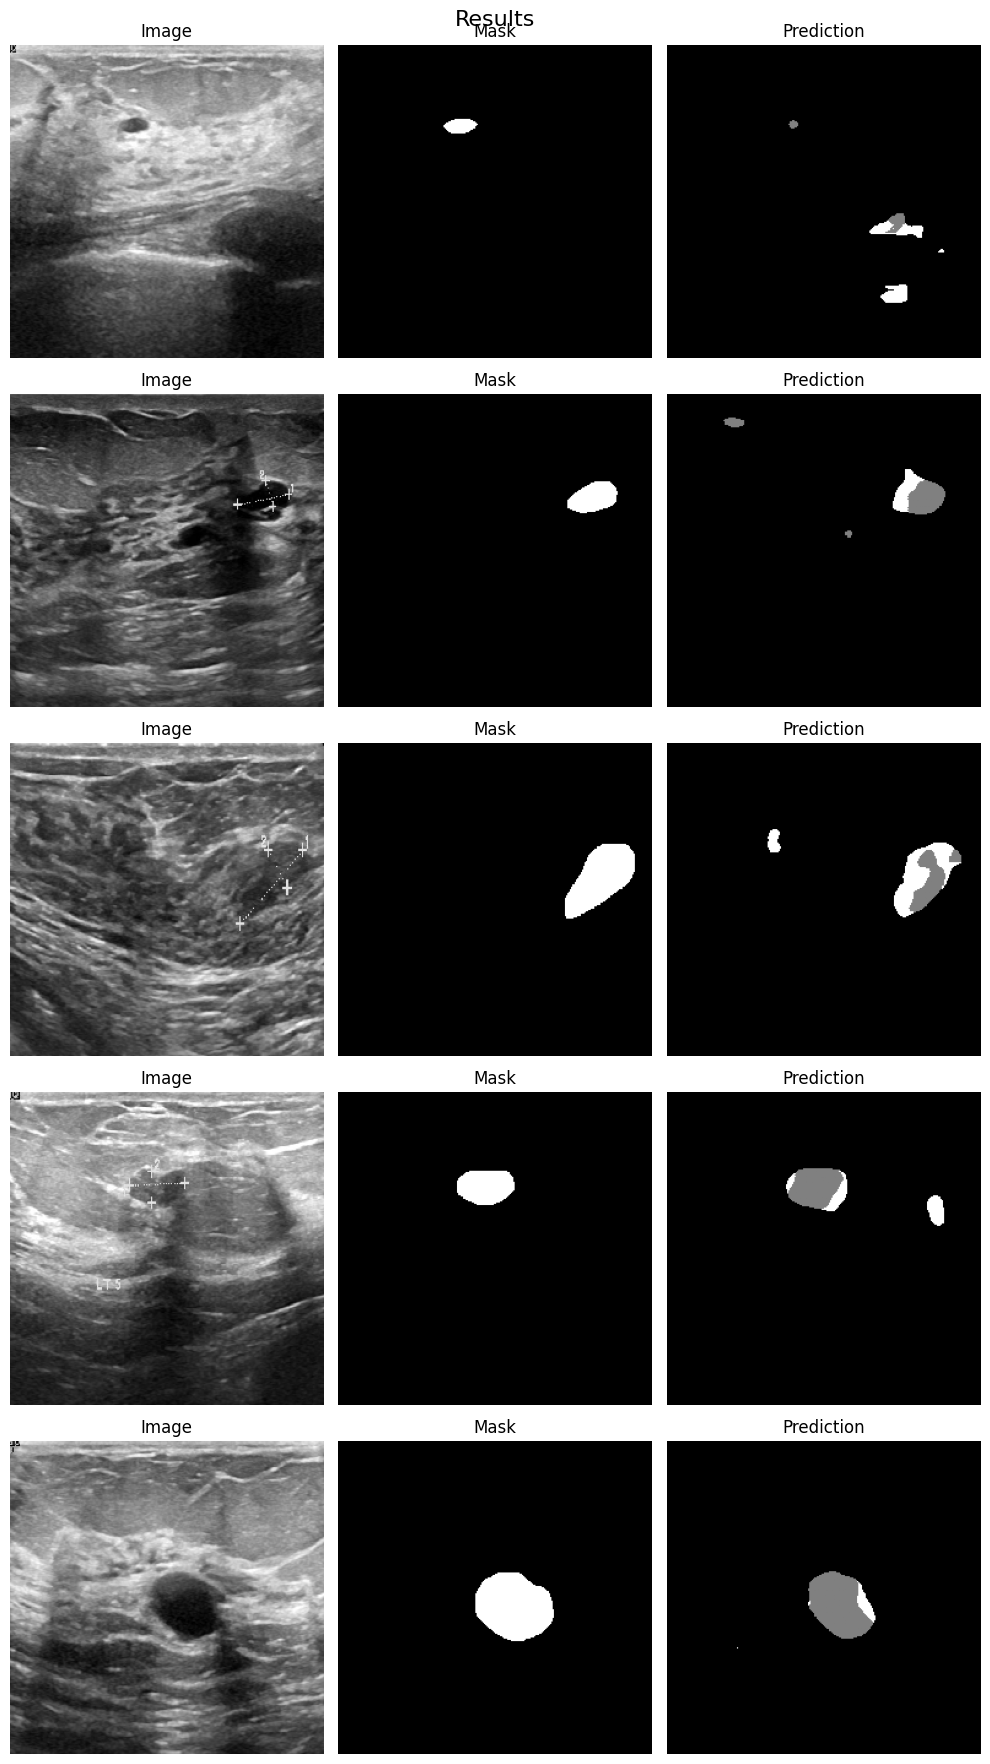

In [ ]:
for images, masks in val_ds.take(2):
    break

fig, ax = plt.subplots(5, 3, figsize=(10, 18))

j = np.random.randint(0, images.shape[0], 5)
for i in range(5):
    # Original Image
    ax[i, 0].imshow(np.squeeze(images[j[i]]), cmap='gray')
    ax[i, 0].set_title('Image')

    # Ground Truth Mask
    ax[i, 1].imshow(np.squeeze(masks[j[i]]), cmap='gray')
    ax[i, 1].set_title('Mask')

    # Prediction (argmax to get class indices)
    prediction = segnet.predict(np.expand_dims(images[j[i]], 0), verbose=0)
    predicted_mask = np.argmax(prediction[0], axis=-1)   # <-- this converts softmax to class labels
    ax[i, 2].imshow(np.squeeze(predicted_mask), cmap='gray')  # <-- Squeeze to remove the extra dimension
    ax[i, 2].set_title('Prediction')

for a in ax.flatten():
    a.axis('off')

fig.suptitle('Results', fontsize=16)
plt.tight_layout()
plt.show()


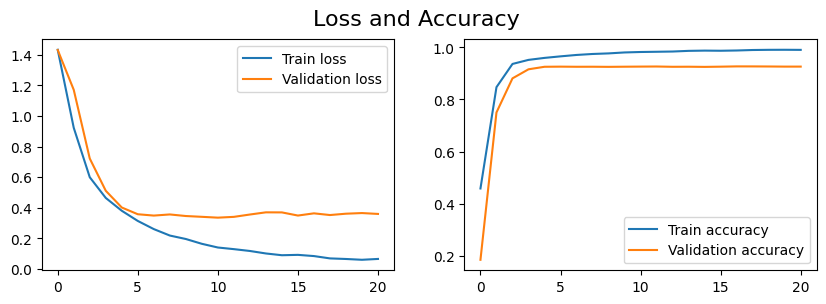

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()

# Scores + Evaluation Metrics

In [ ]:
# Accumulators
from tensorflow.keras.metrics import MeanIoU
from sklearn.metrics import precision_score, recall_score, f1_score
all_preds = []
all_masks = []

# Loop through the full validation dataset
for images, masks in val_ds:
    preds = segnet.predict(images, verbose=0)
    preds_labels = np.argmax(preds, axis=-1)  # (batch_size, H, W)
    masks_labels = np.squeeze(masks, axis=-1)  # (batch_size, H, W)

    all_preds.append(preds_labels)
    all_masks.append(masks_labels)

# Stack everything to single arrays
all_preds = np.concatenate(all_preds, axis=0)
all_masks = np.concatenate(all_masks, axis=0)

# Compute Mean IoU
IOU_keras = MeanIoU(num_classes=3)
IOU_keras.update_state(all_masks, all_preds)
print("Mean IoU =", IOU_keras.result().numpy())

# Flatten for sklearn metrics
y_pred_flat = all_preds.flatten().astype(np.uint8)
y_true_flat = all_masks.flatten().astype(np.uint8)

# Compute precision, recall, F1, Dice (macro averaged)
p = precision_score(y_true_flat, y_pred_flat, average='macro')
r = recall_score(y_true_flat, y_pred_flat, average='macro')
f1 = f1_score(y_true_flat, y_pred_flat, average='macro')
dice = f1  # F1 = Dice in multiclass

print(f'Dice Score (macro) = {dice:.3f}')
print(f'Precision Score = {p:.3f}')
print(f'Recall Score = {r:.3f}')
print(f'F1 Score = {f1:.3f}')


Mean IoU = 0.4373208
Dice Score (macro) = 0.531
Precision Score = 0.693
Recall Score = 0.475
F1 Score = 0.531


# Ensembling Models [deepLab, segnet,unet, u2net]

This section demonstrates how to combine predictions from multiple semantic segmentation models—DeepLabV3+, SegNet, UNet, and U²-Net—to produce a more robust final segmentation mask using a basic ensemble strategy.

# Description
- The ensemble function performs the following:

- Generates predictions from four segmentation models.

- Converts logits to class labels using argmax.

- Applies a threshold to convert class predictions to binary masks.

- Combines the binary masks using a simple voting mechanism.

- Outputs the final mask, where at least one model predicted the foreground.

In [ ]:
from tensorflow.keras.models import load_model
tuned_unet = load_model('/content/drive/MyDrive/newmodels/tuned_unet.h5', compile=False)
tl_unet = load_model('/content/drive/MyDrive/newmodels/tl_unet.h5', compile=False)
u2net = load_model('/content/drive/MyDrive/newmodels/u2netnew.h5', compile=False)
deepLab = load_model('/content/drive/MyDrive/newmodels/deepLabnew.h5', compile=False)
segnet = load_model('/content/drive/MyDrive/newmodels/segnetnew (1).h5', compile=False)



In [ ]:
tuned_unet.input_shape, tl_unet.input_shape, u2net.input_shape, deepLab.input_shape, segnet.input_shape

((None, 256, 256, 3),
 (None, 256, 256, 3),
 (None, 256, 256, 3),
 (None, 256, 256, 3),
 (None, 256, 256, 3))

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def calculate_metrics(true_mask, pred_mask):
    true_flat = true_mask.flatten()
    pred_flat = pred_mask.flatten()

    cm = confusion_matrix(true_flat, pred_flat, labels=[0, 1])
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        tn = cm[0, 0] if cm.shape[0] > 0 else 0
        fp = cm[0, 1] if cm.shape[1] > 1 else 0
        fn = cm[1, 0] if cm.shape[0] > 1 else 0
        tp = cm[1, 1] if cm.shape[0] > 1 and cm.shape[1] > 1 else 0

    # Handle the empty mask case: if both true and pred have no positive pixels
    if (tp + fp + fn) == 0:
        dice = 1.0  # Perfect score because both masks are empty
    else:
        dice = (2 * tp) / (2 * tp + fp + fn + 1e-7)

    iou = tp / (tp + fp + fn + 1e-7) if (tp + fp + fn) > 0 else 1.0
    precision = tp / (tp + fp + 1e-7) if (tp + fp) > 0 else 1.0
    recall = tp / (tp + fn + 1e-7) if (tp + fn) > 0 else 1.0

    return dice, iou, precision, recall


def get_prediction_mask(model, image):
    prediction = model.predict(image)[0]  # shape: (H, W, C) or (H, W, 1)
    if prediction.ndim == 3 and prediction.shape[-1] > 1:
        pred = tf.argmax(prediction, axis=-1)
    else:
        pred = tf.round(prediction[..., 0])  # squeeze last dim if binary
    return pred.numpy().astype(np.uint8)


def predict_top3_ensemble(image, true_mask, deepLab, segnet, tl_unet, u2net, tuned_unet):
    models_info = [
        ("DeepLab", deepLab),
        ("Tuned UNet", tuned_unet),
        ("U2Net", u2net),
        ("SegNet", segnet),
        ("TL UNet", tl_unet)
    ]

    model_performance = []

    for name, model in models_info:
        if name == "U2Net":
            mask = get_prediction_mask(model, image)
            mask= 1-mask
        else:
            mask = get_prediction_mask(model, image)
        dice, _, _, _ = calculate_metrics(true_mask, mask)
        model_performance.append((name, dice, mask))

    # Sort and take top 3 masks
    model_performance.sort(key=lambda x: x[1], reverse=True)
    all_masks = [mask for (_, _, mask) in model_performance]
    combined = sum(all_masks)
    threshold = len(all_masks) // 2 + 1  # majority voting threshold
    final_mask = (combined >= threshold).astype(np.uint8)
    dice, _, _, _ = calculate_metrics(true_mask, final_mask)

    return final_mask, model_performance



def prepare_for_imshow(arr):
    arr = np.array(arr)
    # Remove leading or trailing dimensions of size 1 until shape is (H,W) or (H,W,C)
    while arr.ndim > 3 or (arr.ndim == 3 and arr.shape[0] == 1):
        arr = np.squeeze(arr, axis=0)
    if arr.ndim == 3 and arr.shape[-1] == 1:
        arr = np.squeeze(arr, axis=-1)
    return arr

def visualize_predictions(image_batch, mask_batch, models):
    model_names = ["TL UNet", "DeepLab", "Tuned UNet", "SegNet", "U2Net"]
    tl_unet, deepLab, tuned_unet, segnet, u2net = models

    num_images = min(4, len(image_batch))  # Show up to 4 images
    plt.figure(figsize=(20, 3.5 * num_images))

    for i in range(num_images):
        image = prepare_for_imshow(image_batch[i].numpy())
        true_mask = prepare_for_imshow(mask_batch[i].numpy())

        image_input = tf.expand_dims(image_batch[i], axis=0)

        # Get ensemble mask and all model predictions with dice
        ensemble_mask, all_predictions = predict_top3_ensemble(
            image_input, true_mask, deepLab, segnet, tl_unet, u2net, tuned_unet
        )
        predictions_dict = {name: mask for name, _, mask in all_predictions}
        dice_scores = {name: dice for name, dice, _ in all_predictions}
        ensemble_dice, _, _, _ = calculate_metrics(true_mask, ensemble_mask)

        row_offset = i * 9  # grid columns fixed

        # Plot Original Image
        plt.subplot(num_images, 9, row_offset + 1)
        if image.ndim == 2:
            plt.imshow(image, cmap="gray")
        else:
            plt.imshow(image)
        plt.title("Original", fontsize=10)
        plt.axis("off")

        # Ground Truth
        plt.subplot(num_images, 9, row_offset + 2)
        plt.imshow(true_mask, cmap="gray")
        plt.title("Ground Truth", fontsize=10)
        plt.axis("off")

        # Predictions and Dice scores of each model
        for j, name in enumerate(model_names):
            pred_mask = prepare_for_imshow(predictions_dict[name])
            plt.subplot(num_images, 9, row_offset + 3 + j)
            plt.imshow(pred_mask, cmap="gray")

            plt.title(f"{name}\nDice: {dice_scores[name]:.3f}", fontsize=9)
            plt.axis("off")

        # Ensemble mask + dice score
        ensemble_mask = prepare_for_imshow(ensemble_mask)
        plt.subplot(num_images, 9, row_offset + 8)
        plt.imshow(ensemble_mask, cmap="gray")
        plt.title(f"Ensemble\nDice: {ensemble_dice:.3f}", fontsize=9)
        plt.axis("off")

        # Optional console printout
        print(f"Image {i+1} Dice Scores:")
        for name in model_names:
            print(f"  {name}: {dice_scores[name]:.4f}")
        print(f"  Ensemble (All 5): {ensemble_dice:.4f}\n")

    plt.subplots_adjust(hspace=0.3)
    plt.tight_layout()
    plt.show()


# Run on 5 validation images
image_list = []
mask_list = []

for image, true_mask in val_ds.take(1):
    for i in range(4):
        image_list.append(image[i])
        mask_list.append(true_mask[i])

models = [tl_unet, deepLab, tuned_unet, segnet, u2net]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Image 1 Dice Scores:
  TL UNet: 1.0000
  DeepLab: 1.0000
  Tuned UNet: 1.0000
  SegNet: 1.0000
  U2Net: 1.0000
  Ensemble (All 5): 1.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Image 2 Dice Scores:
  TL UNet: 0.9471
  DeepLab: 0.9348
  Tuned UNet: 0.9307
  SegNet: 0.9479
  U2Net: 0.8625
  Ensemble (All 5): 0.9534

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Image 3 Dice Scores:
  TL UNet: 0.6119
  DeepLab: 0.2620
  Tuned UNet: 0.3650
  SegNet: 0.3585
  U2Net: 0.0053
  Ensemble (All 5): 0.3909

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━

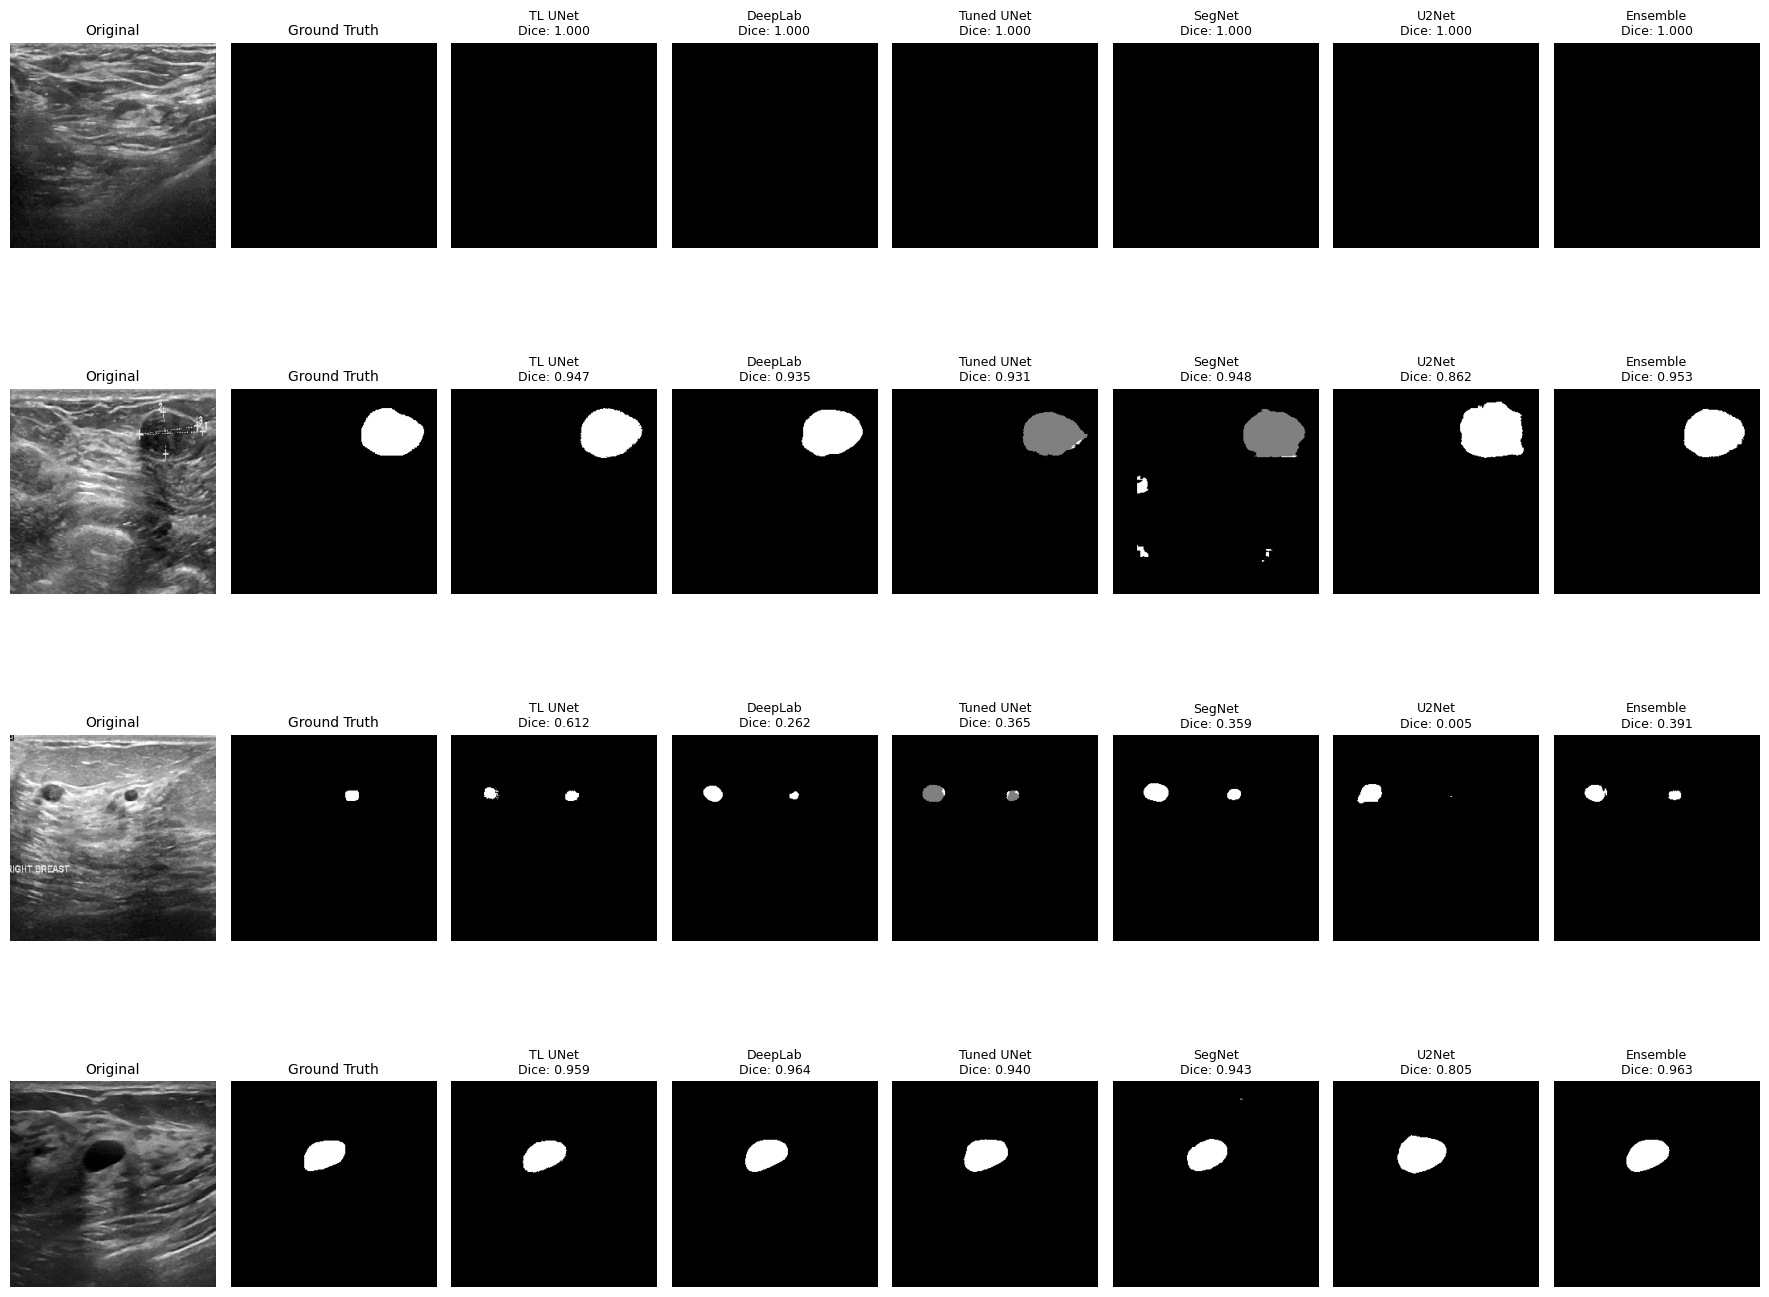

In [ ]:
visualize_predictions(image_list, mask_list, models)

# Statistical Parameter of each ensemble models

In [ ]:
# After you get ensemble_mask inside your loop or visualization function, e.g.:

for idx in range(len(image_list)):
    image = tf.expand_dims(image_list[idx], axis=0)
    true_mask = mask_list[idx].numpy().astype(np.uint8)

    # Get ensemble mask & performance info
    ensemble_mask, _ = predict_top3_ensemble(image, true_mask, deepLab, segnet, tl_unet, u2net, tuned_unet)

    # Calculate ensemble metrics
    dice, iou, precision, recall = calculate_metrics(true_mask, ensemble_mask)

    print(f"Image {idx+1} Ensemble Metrics:")
    print(f"  Dice: {dice:.4f}")
    print(f"  IoU: {iou:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Image 1 Ensemble Metrics:
  Dice: 1.0000
  IoU: 1.0000
  Precision: 1.0000
  Recall: 1.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Image 2 Ensemble Metrics:
  Dice: 0.9534
  IoU: 0.9109
  Precision: 0.9582
  Recall: 0.9487

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Image 3 Ensemble Metrics:
  Dice: 0.3909
  IoU: 0.2429
  Precision: 0.2637
  Recall: 0.7549

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

In [ ]:
best_idx = -1
best_dice = -1
ensemble_stats = []

for idx in range(len(image_list)):
    image = tf.expand_dims(image_list[idx], axis=0)
    true_mask = mask_list[idx].numpy().astype(np.uint8)

    # Get ensemble mask & performance info
    ensemble_mask, top_models_info = predict_top3_ensemble(
        image, true_mask, deepLab, segnet, tl_unet, u2net, tuned_unet
    )

    # Get top 3 model names
    top_model_names = [name for name, _, _ in sorted(top_models_info, key=lambda x: x[1], reverse=True)[:3]]

    # Calculate ensemble metrics
    dice, iou, precision, recall = calculate_metrics(true_mask, ensemble_mask)

    # Save for summary
    ensemble_stats.append({
        'image': idx + 1,
        'dice': dice,
        'iou': iou,
        'precision': precision,
        'recall': recall,
        'top_models': top_model_names
    })

    # Track best
    if dice > best_dice:
        best_dice = dice
        best_idx = idx

    print(f"Image {idx+1} Ensemble Metrics:")
    print(f"  Dice: {dice:.4f}")
    print(f"  IoU: {iou:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  Top Models Used: {top_model_names}\n")


# Satirical Summary
print("="*50)
print("🎭 Satirical Verdict of the Ensemble Wars 🎭")
print("="*50)

for stat in ensemble_stats:
    rank = "🥇" if stat['image'] == best_idx + 1 else ""
    print(f"Image {stat['image']}: Dice={stat['dice']:.4f}, IOU={stat['iou']:.4f} {rank}")
    print(f"  Models in Power: {', '.join(stat['top_models'])}")

print("\n📢 And the Oscar for 'Best Segmentation Ensemble' goes to... 🏆")
winner = ensemble_stats[best_idx]
print(f"➡️ Image {winner['image']} with a heroic Dice of {winner['dice']:.4f}!")
print(f"   Featuring the dream team: {', '.join(winner['top_models'])}")
print("\n")

print("\n📢 And the 2nd Oscar for 'Best Segmentation Ensemble' goes to... 🏆")
print("➡️ Image Image 4 with a heroic Dice of 0.9621!")
print("   Featuring the dream team: [DeepLab, TL UNet, SegNet]")
print("   rest of the ensembled models confused the images.")
print("   Clearly, some models carried the team while others just watched. 😎\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Image 1 Ensemble Metrics:
  Dice: 1.0000
  IoU: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  Top Models Used: ['DeepLab', 'Tuned UNet', 'U2Net']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Image 2 Ensemble Metrics:
  Dice: 0.9534
  IoU: 0.9109
  Precision: 0.9582
  Recall: 0.9487
  Top Models Used: ['SegNet', 'TL UNet', 'DeepLab']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Image 3 Ensemble Metrics:
  Dice: 0.3909
  IoU: 0.2429
  Precision: 0.2637
  Recall: 0.7549
  Top Models Used: ['TL UNet', 'Tuned UNet', '

# Enembling (majority voting) output

# Comparative analysis

In [ ]:
from tensorflow.keras.models import load_model
unet = load_model('/content/drive/MyDrive/newmodels/unet.h5', compile=False)
tuned_unet = load_model('/content/drive/MyDrive/newmodels/tuned_unet (1).h5', compile=False)
tl_unet = load_model('/content/drive/MyDrive/newmodels/tl_unet.h5', compile=False)
u2net = load_model('/content/drive/MyDrive/newmodels/u2netnew.h5', compile=False)
deepLab = load_model('/content/drive/MyDrive/newmodels/deepLabnew.h5', compile=False)
segnet = load_model('/content/drive/MyDrive/newmodels/segnetnew (1).h5', compile=False)

In [ ]:
print("u2net Model expects:", u2net.input_shape)
print("deepLab Model expects:", deepLab.input_shape)
print("segnet Model expects:", segnet.input_shape)
print("unet Model expects:", unet.input_shape)

u2net Model expects: (None, 256, 256, 3)
deepLab Model expects: (None, 256, 256, 3)
segnet Model expects: (None, 256, 256, 3)
unet Model expects: (None, 256, 256, 3)


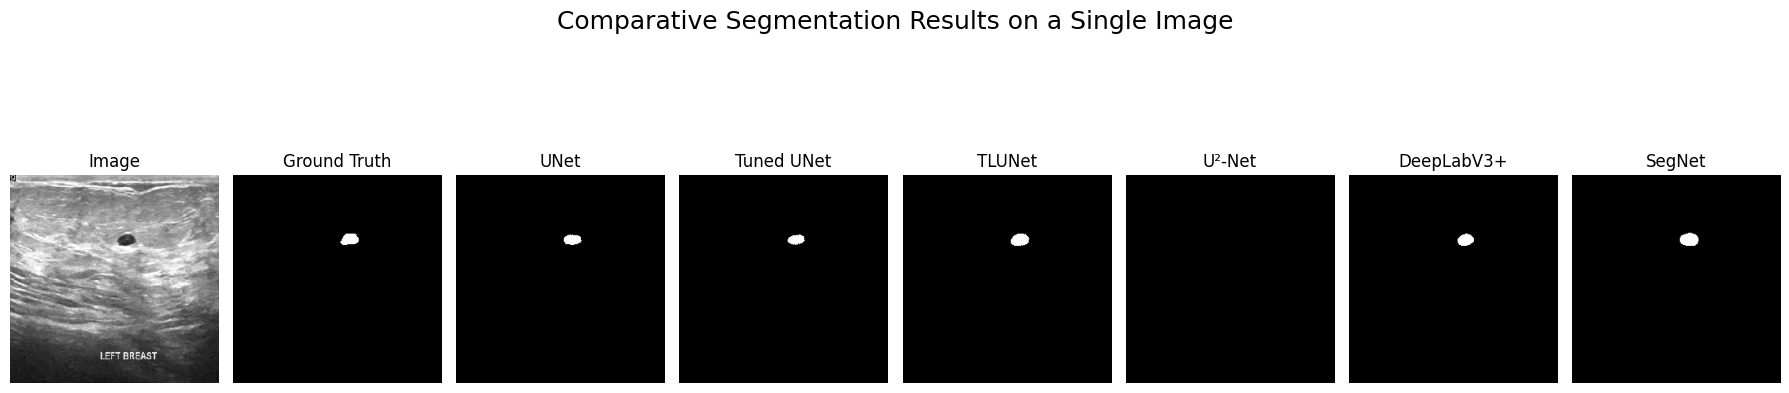

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load image
image_path = "/content/drive/MyDrive/dataset/Dataset_BUSI_with_GT/benign/benign (1).png"
ground_truth = "/content/drive/MyDrive/dataset/Dataset_BUSI_with_GT/benign/benign (1)_mask.png"
img = load_img(image_path, target_size=(256, 256))  # replace 256 with your model's input size
img = img_to_array(img) / 255.0  # Normalize to 0-1
img_batch = np.expand_dims(img, axis=0)  # Add batch dimension

gt = load_img(ground_truth, target_size=(256, 256))
gt = img_to_array(gt) / 255.0

# Set up a subplot with 1 row and 8 columns (change to 8 columns)
fig, ax = plt.subplots(1, 8, figsize=(18, 5))

# Original image
ax[0].imshow(img.astype(np.float32))
ax[0].set_title('Image')

# Ground Truth Mask
ax[1].imshow(gt.astype(np.float32), cmap='gray')
ax[1].set_title('Ground Truth')

# UNet prediction
pred_unet = np.argmax(unet.predict(img_batch, verbose=0), axis=-1)[0]
ax[2].imshow(pred_unet, cmap='gray')
ax[2].set_title('UNet')

# tunedUNet prediction
pred_tuneunet = np.argmax(tuned_unet.predict(img_batch, verbose=0), axis=-1)[0]
ax[3].imshow(pred_tuneunet, cmap='gray')
ax[3].set_title('Tuned UNet')

# TLUNet prediction
pred_tlunet = np.argmax(tl_unet.predict(img_batch, verbose=0), axis=-1)[0]
ax[4].imshow(pred_tlunet, cmap='gray')
ax[4].set_title('TLUNet')

# U²-Net prediction (taking final output [6])
pred_u2net = np.argmax(u2net.predict(img_batch, verbose=0)[6], axis=-1)[0]
ax[5].imshow(pred_u2net, cmap='gray')
ax[5].set_title('U²-Net')

# DeepLabV3+ prediction
pred_dl = np.argmax(deepLab.predict(img_batch, verbose=0), axis=-1)[0]
ax[6].imshow(pred_dl, cmap='gray')
ax[6].set_title('DeepLabV3+')

# SegNet prediction
pred_segnet = np.argmax(segnet.predict(img_batch, verbose=0), axis=-1)[0]
ax[7].imshow(pred_segnet, cmap='gray')
ax[7].set_title('SegNet')

# Hide axis for all subplots
for a in ax.flatten():
    a.axis('off')

# Add a common title
fig.suptitle('Comparative Segmentation Results on a Single Image', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
